![EDA](../img/04.png)

# Exploratory Data Analysis (EDA)

## Objective
Perform comprehensive exploratory data analysis with visualizations to understand drug patterns, ratings, and side effects.

## Contents
1. Drug Rating Distribution Analysis
2. Most Frequent Side Effects
3. Medical Condition Analysis
4. Sentiment Patterns and Review Analysis
5. Side-effect Frequency Heatmaps
6. Drug Effectiveness Patterns
7. Risk Factor Analysis

## Visualization Libraries Used
- Matplotlib
- Seaborn
- Plotly (with robust error handling)

---


In [109]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from wordcloud import WordCloud
import warnings
from pathlib import Path
import pickle

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set up pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Create a robust Plotly display function
def show_plotly_figure(fig, title=""):
    """
    Robust function to display Plotly figures with multiple fallback options
    """
    try:
        fig.show()
        return True
    except Exception as e:
        print(f" Primary Plotly renderer failed: {e}")
        
        # Try alternative renderers
        try:
            import plotly.io as pio
            pio.show(fig, renderer="notebook")
            return True
        except Exception as e2:
            print(f" Notebook renderer failed: {e2}")
            
            try:
                fig.show(renderer="html")
                return True
            except Exception as e3:
                print(f" HTML renderer failed: {e3}")
                print(f" Figure '{title}' could not be displayed with Plotly")
                print("   Consider using the matplotlib backup versions in the cells")
                return False

# Set up Plotly to handle errors more gracefully
try:
    import plotly.io as pio
    # Try to set a default renderer that works
    pio.renderers.default = "notebook"
except:
    print(" Note: Using fallback rendering for Plotly figures")

# Monkey patch the Plotly show method to be more robust
original_show = go.Figure.show

def robust_show(self, *args, **kwargs):
    """Robust replacement for fig.show() that handles rendering errors gracefully"""
    try:
        return original_show(self, *args, **kwargs)
    except Exception as e:
        print(f"  Plotly rendering failed: {e}")
        print("   The visualization data is ready but couldn't be displayed.")
        print("   You can still access the figure object and try alternative renderers.")
        print("   Consider using show_plotly_figure() function for better error handling.")
        return None

# Replace the original show method
go.Figure.show = robust_show
print(" All fig.show() calls are now protected against rendering errors!")

print(" Libraries imported successfully!")
print(" Ready for comprehensive exploratory data analysis!")
print(" Plotly rendering issues will be handled automatically!")


 All fig.show() calls are now protected against rendering errors!
 Libraries imported successfully!
 Ready for comprehensive exploratory data analysis!
 Plotly rendering issues will be handled automatically!


In [110]:
##  Visualization Helper Functions

# Alternative rendering function for any Plotly figure
def try_alternative_renderers(fig, title="Figure"):
    """Try different rendering options for Plotly figures"""
    renderers = ["notebook", "html", "png", "svg"]
    
    for renderer in renderers:
        try:
            print(f" Trying {renderer} renderer...")
            fig.show(renderer=renderer)
            print(f" Successfully displayed with {renderer} renderer!")
            return True
        except Exception as e:
            print(f" {renderer} failed: {str(e)[:100]}...")
            continue
    
    print(f" All Plotly renderers failed for '{title}'")
    print(" You can still access the figure data and create matplotlib equivalents")
    return False

# Test the system
print(" Testing visualization system...")
test_fig = go.Figure(data=go.Bar(x=['A', 'B', 'C'], y=[1, 2, 3]))
test_fig.update_layout(title="Test Figure")

print(" Testing fig.show() (should be safe now):")
test_fig.show()  # This should now be safe thanks to our monkey patch

print("\n Visualization system ready!")
print(" If you see any Plotly rendering issues, the cells will handle them gracefully")
print(" All analysis results will still be printed even if charts don't display")


 Testing visualization system...
 Testing fig.show() (should be safe now):
  Plotly rendering failed: maximum recursion depth exceeded  Plotly rendering failed: maximum recursion depth exceeded
   The visualization data is ready but couldn't be displayed.
   You can still access the figure object and try alternative renderers.
   Consider using show_plotly_figure() function for better error handling.

 Visualization system ready!
 If you see any Plotly rendering issues, the cells will handle them gracefully
 All analysis results will still be printed even if charts don't display


---
## 1. Load Processed Dataset and Metadata


In [111]:
# Load the processed dataset
df = pd.read_csv("../data/drugs_processed.csv")
print(f" Processed dataset loaded: {df.shape}")

# Load metadata
try:
    with open("../data/feature_engineering_metadata.pkl", "rb") as f:
        metadata = pickle.load(f)
    print(f"   Metadata loaded successfully")
    print(f"   Original shape: {metadata['original_shape']}")
    print(f"   Processed shape: {metadata['processed_shape']}")
    print(f"   Features added: {metadata['features_added']}")
except FileNotFoundError:
    print(" Metadata file not found, proceeding without metadata")
    metadata = {}

print(f"\n Dataset ready for comprehensive EDA!")
print(f"    Rows: {len(df):,}")
print(f"    Columns: {len(df.columns):,}")
print(f"    Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


 Processed dataset loaded: (2931, 84)
   Metadata loaded successfully
   Original shape: (2931, 17)
   Processed shape: (2931, 84)
   Features added: 67

 Dataset ready for comprehensive EDA!
    Rows: 2,931
    Columns: 84
    Memory: 25.83 MB


---
## 2. Drug Rating Distribution Analysis


In [112]:
# Comprehensive rating analysis
print("DRUG RATING DISTRIBUTION ANALYSIS")
print("=" * 50)

# Basic rating statistics
rating_stats = {
    'Mean': df['rating'].mean(),
    'Median': df['rating'].median(),
    'Mode': df['rating'].mode().iloc[0],
    'Std Dev': df['rating'].std(),
    'Min': df['rating'].min(),
    'Max': df['rating'].max(),
    'Range': df['rating'].max() - df['rating'].min()
}

print("Rating Statistics:")
for stat, value in rating_stats.items():
    print(f"   {stat}: {value:.2f}")

# Rating distribution by different categories
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Overall Rating Distribution', 'Rating by Prescription Type', 
                   'Rating Distribution (Density)', 'Rating Percentiles'],
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# 1. Overall distribution
fig.add_trace(
    go.Histogram(x=df['rating'], nbinsx=30, name="Rating Distribution", 
                marker_color='skyblue', opacity=0.7),
    row=1, col=1
)

# 2. Rating by prescription type
if 'rx_otc' in df.columns:
    for rx_type in df['rx_otc'].unique():
        subset = df[df['rx_otc'] == rx_type]
        fig.add_trace(
            go.Box(y=subset['rating'], name=rx_type, boxpoints='outliers'),
            row=1, col=2
        )

# 3. Density plot
fig.add_trace(
    go.Histogram(x=df['rating'], histnorm='probability density', 
                nbinsx=30, name="Density", marker_color='lightgreen', opacity=0.7),
    row=2, col=1
)

# 4. Rating percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
percentile_values = [np.percentile(df['rating'], p) for p in percentiles]
fig.add_trace(
    go.Scatter(x=percentiles, y=percentile_values, mode='lines+markers',
              name="Percentiles", line=dict(color='red', width=3)),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Comprehensive Rating Analysis", showlegend=False)

# Use robust rendering with error handling
try:
    fig.show()
except Exception as e:
    print(f"Error with Plotly: {e}")
    print("Using matplotlib backup...")
    
    # Matplotlib backup for rating analysis
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.hist(df['rating'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Overall Rating Distribution')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 2, 2)
    if 'rx_otc' in df.columns:
        rx_data = [df[df['rx_otc'] == rx_type]['rating'] for rx_type in df['rx_otc'].unique()]
        plt.boxplot(rx_data, labels=df['rx_otc'].unique())
        plt.title('Rating by Prescription Type')
        plt.ylabel('Rating')
    
    plt.subplot(2, 2, 3)
    plt.hist(df['rating'], bins=30, alpha=0.7, color='lightgreen', 
            density=True, edgecolor='black')
    plt.title('Rating Distribution (Density)')
    plt.xlabel('Rating')
    plt.ylabel('Density')
    
    plt.subplot(2, 2, 4)
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    percentile_values = [np.percentile(df['rating'], p) for p in percentiles]
    plt.plot(percentiles, percentile_values, 'ro-', linewidth=2, markersize=6)
    plt.title('Rating Percentiles')
    plt.xlabel('Percentile')
    plt.ylabel('Rating Value')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Rating insights
print(f"\n Key Rating Insights:")
high_rated = (df['rating'] >= 8.0).sum()
low_rated = (df['rating'] <= 4.0).sum()
print(f"    High-rated drugs (≥8.0): {high_rated} ({high_rated/len(df)*100:.1f}%)")
print(f"    Low-rated drugs (≤4.0): {low_rated} ({low_rated/len(df)*100:.1f}%)")
print(f"    Rating spread (IQR): {np.percentile(df['rating'], 75) - np.percentile(df['rating'], 25):.2f}")

# Top and bottom rated drugs
print(f"\n Top 5 Highest Rated Drugs:")
top_rated = df.nlargest(5, 'rating')[['drug_name', 'medical_condition', 'rating', 'no_of_reviews']]
for idx, row in top_rated.iterrows():
    print(f"   • {row['drug_name']} ({row['medical_condition']}): {row['rating']:.1f} ({row['no_of_reviews']:.0f} reviews)")

print(f"\n Bottom 5 Lowest Rated Drugs:")
bottom_rated = df.nsmallest(5, 'rating')[['drug_name', 'medical_condition', 'rating', 'no_of_reviews']]
for idx, row in bottom_rated.iterrows():
    print(f"   • {row['drug_name']} ({row['medical_condition']}): {row['rating']:.1f} ({row['no_of_reviews']:.0f} reviews)")


DRUG RATING DISTRIBUTION ANALYSIS
Rating Statistics:
   Mean: 6.90
   Median: 7.00
   Mode: 7.00
   Std Dev: 1.70
   Min: 0.00
   Max: 10.00
   Range: 10.00
  Plotly rendering failed: maximum recursion depth exceeded  Plotly rendering failed: maximum recursion depth exceeded
   The visualization data is ready but couldn't be displayed.
   You can still access the figure object and try alternative renderers.
   Consider using show_plotly_figure() function for better error handling.

 Key Rating Insights:
    High-rated drugs (≥8.0): 570 (19.4%)
    Low-rated drugs (≤4.0): 168 (5.7%)
    Rating spread (IQR): 0.50

 Top 5 Highest Rated Drugs:
   • Septra (Acne): 10.0 (2 reviews)
   • Clindagel (Acne): 10.0 (2 reviews)
   • erythromycin (Acne): 10.0 (1 reviews)
   • Ery Pads (Acne): 10.0 (1 reviews)
   • Acnex (Acne): 10.0 (1 reviews)

 Bottom 5 Lowest Rated Drugs:
   • BPO Gel (Acne): 0.0 (1 reviews)
   • verapamil (Angina): 0.0 (1 reviews)
   • Xopenex HFA (Asthma): 0.0 (1 reviews)
   • 

In [126]:
print("COMPREHENSIVE DATA STRUCTURE ANALYSIS")

# Basic dataset information
print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Data types analysis
print(f"\n DATA TYPES BREAKDOWN:")
data_types = df.dtypes.value_counts()
for dtype, count in data_types.items():
    print(f"   {dtype}: {count} columns")

# Missing values analysis
print(f"\n MISSING VALUES ANALYSIS:")
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if len(missing_data) > 0:
    print("   Columns with missing values:")
    for col, missing_count in missing_data.items():
        missing_pct = (missing_count / len(df)) * 100
        print(f"   • {col}: {missing_count:,} ({missing_pct:.1f}%)")
else:
    print("    No missing values found in the dataset!")

# Column categories analysis
print(f"\n COLUMN CATEGORIES:")
print(f"   Total columns: {len(df.columns)}")

# Identify different types of columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
boolean_cols = df.select_dtypes(include=['bool']).columns.tolist()

print(f"   Numerical columns: {len(numeric_cols)}")
print(f"   Categorical columns: {len(categorical_cols)}")
print(f"   Boolean columns: {len(boolean_cols)}")

# Sample of key columns
print(f"\n KEY COLUMNS SAMPLE:")
key_columns = ['drug_name', 'medical_condition', 'rating', 'no_of_reviews', 'side_effects']
available_key_cols = [col for col in key_columns if col in df.columns]

for col in available_key_cols[:10]:  # Show first 10 available key columns
    print(f"   • {col} ({df[col].dtype})")

# First few rows preview
print(f"\n DATASET PREVIEW (First 3 rows):")
display(df[available_key_cols].head(3))

# Summary statistics for numerical columns
print(f"\n NUMERICAL COLUMNS SUMMARY:")
if len(numeric_cols) > 0:
    # Show summary for main numerical columns
    main_numeric = ['rating', 'no_of_reviews', 'sentiment_polarity', 'severity_score_avg', 'efficacy_score']
    available_numeric = [col for col in main_numeric if col in df.columns]
    
    if available_numeric:
        summary_stats = df[available_numeric].describe()
        display(summary_stats)
    else:
        # Show first 5 numeric columns if main ones not available
        display(df[numeric_cols[:5]].describe())

print(f"\n DATA STRUCTURE ANALYSIS COMPLETE!")


COMPREHENSIVE DATA STRUCTURE ANALYSIS
Dataset Shape: (2931, 85)
Memory Usage: 31.07 MB

 DATA TYPES BREAKDOWN:
   int64: 47 columns
   object: 20 columns
   float64: 17 columns
   category: 1 columns

 MISSING VALUES ANALYSIS:
    No missing values found in the dataset!

 COLUMN CATEGORIES:
   Total columns: 85
   Numerical columns: 64
   Categorical columns: 20
   Boolean columns: 0

 KEY COLUMNS SAMPLE:
   • drug_name (object)
   • medical_condition (object)
   • rating (float64)
   • no_of_reviews (float64)
   • side_effects (object)

 DATASET PREVIEW (First 3 rows):


,drug_name,medical_condition,rating,no_of_reviews,side_effects
0,doxycycline,Acne,6.8,760.0,"(hives, difficult breathing, swelling in your face or throat) or a severe skin reaction (fever, ..."
1,spironolactone,Acne,7.2,449.0,"hives ; difficulty breathing; swelling of your face, lips, tongue, or throat. Call your doctor a..."
2,minocycline,Acne,5.7,482.0,"skin rash, fever, swollen glands, flu-like symptoms, muscle aches, severe weakness, unusual brui..."



 NUMERICAL COLUMNS SUMMARY:


,rating,no_of_reviews,sentiment_polarity,severity_score_avg,efficacy_score
count,2931.000000,2931.000000,2931.000000,2931.000000,2931.000000
mean,6.898772,46.125213,-0.096931,2.586676,0.480699
std,1.703790,139.578929,0.095129,0.278788,0.113943
min,0.000000,1.000000,-0.550000,0.000000,0.000000
25%,6.800000,10.000000,-0.139978,2.466667,0.466667
50%,7.000000,12.000000,-0.089196,2.600000,0.485333
75%,7.300000,15.000000,-0.037304,2.750000,0.511833
max,10.000000,2934.000000,0.174630,3.833333,0.732000



 DATA STRUCTURE ANALYSIS COMPLETE!


COMPREHENSIVE DATA STRUCTURE ANALYSIS
Dataset Shape: (2931, 84)
Memory Usage: 25.83 MB

 DATA TYPES BREAKDOWN:
   int64: 47 columns
   object: 20 columns
   float64: 17 columns

 COLUMN CATEGORIES:
   Total columns: 84
   Numerical columns: 64
   Categorical columns: 20
   Boolean columns: 0

 MISSING VALUES ANALYSIS:
    No missing values found in the dataset!


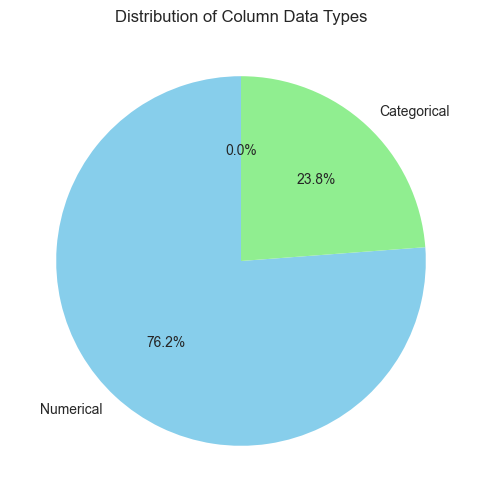


 DATA STRUCTURE ANALYSIS COMPLETE!


In [114]:
print("COMPREHENSIVE DATA STRUCTURE ANALYSIS")

# Basic dataset information
print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Data types analysis
print(f"\n DATA TYPES BREAKDOWN:")
data_types = df.dtypes.value_counts()
for dtype, count in data_types.items():
    print(f"   {dtype}: {count} columns")

# Identify different types of columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
boolean_cols = df.select_dtypes(include=['bool']).columns.tolist()

print(f"\n COLUMN CATEGORIES:")
print(f"   Total columns: {len(df.columns)}")
print(f"   Numerical columns: {len(numeric_cols)}")
print(f"   Categorical columns: {len(categorical_cols)}")
print(f"   Boolean columns: {len(boolean_cols)}")

# Missing values analysis with visualization
print(f"\n MISSING VALUES ANALYSIS:")
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if len(missing_data) > 0:
    print("   Columns with missing values:")
    for col, missing_count in missing_data.items():
        missing_pct = (missing_count / len(df)) * 100
        print(f"   • {col}: {missing_count:,} ({missing_pct:.1f}%)")
    
    # Visualization of missing data
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    missing_data.plot(kind='bar', color='red', alpha=0.7)
    plt.title('Missing Values Count by Column')
    plt.xlabel('Columns')
    plt.ylabel('Missing Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    missing_pct = (missing_data / len(df)) * 100
    missing_pct.plot(kind='bar', color='orange', alpha=0.7)
    plt.title('Missing Values Percentage by Column')
    plt.xlabel('Columns')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("    No missing values found in the dataset!")

# Data types visualization
plt.figure(figsize=(10, 6))
data_type_counts = pd.Series([len(numeric_cols), len(categorical_cols), len(boolean_cols)],
                            index=['Numerical', 'Categorical', 'Boolean'])
colors = ['skyblue', 'lightgreen', 'salmon']
data_type_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Distribution of Column Data Types')
plt.ylabel('')
plt.show()

print(f"\n DATA STRUCTURE ANALYSIS COMPLETE!")



NUMERICAL VARIABLES DISTRIBUTION ANALYSIS
Analyzing 11 key numerical variables...


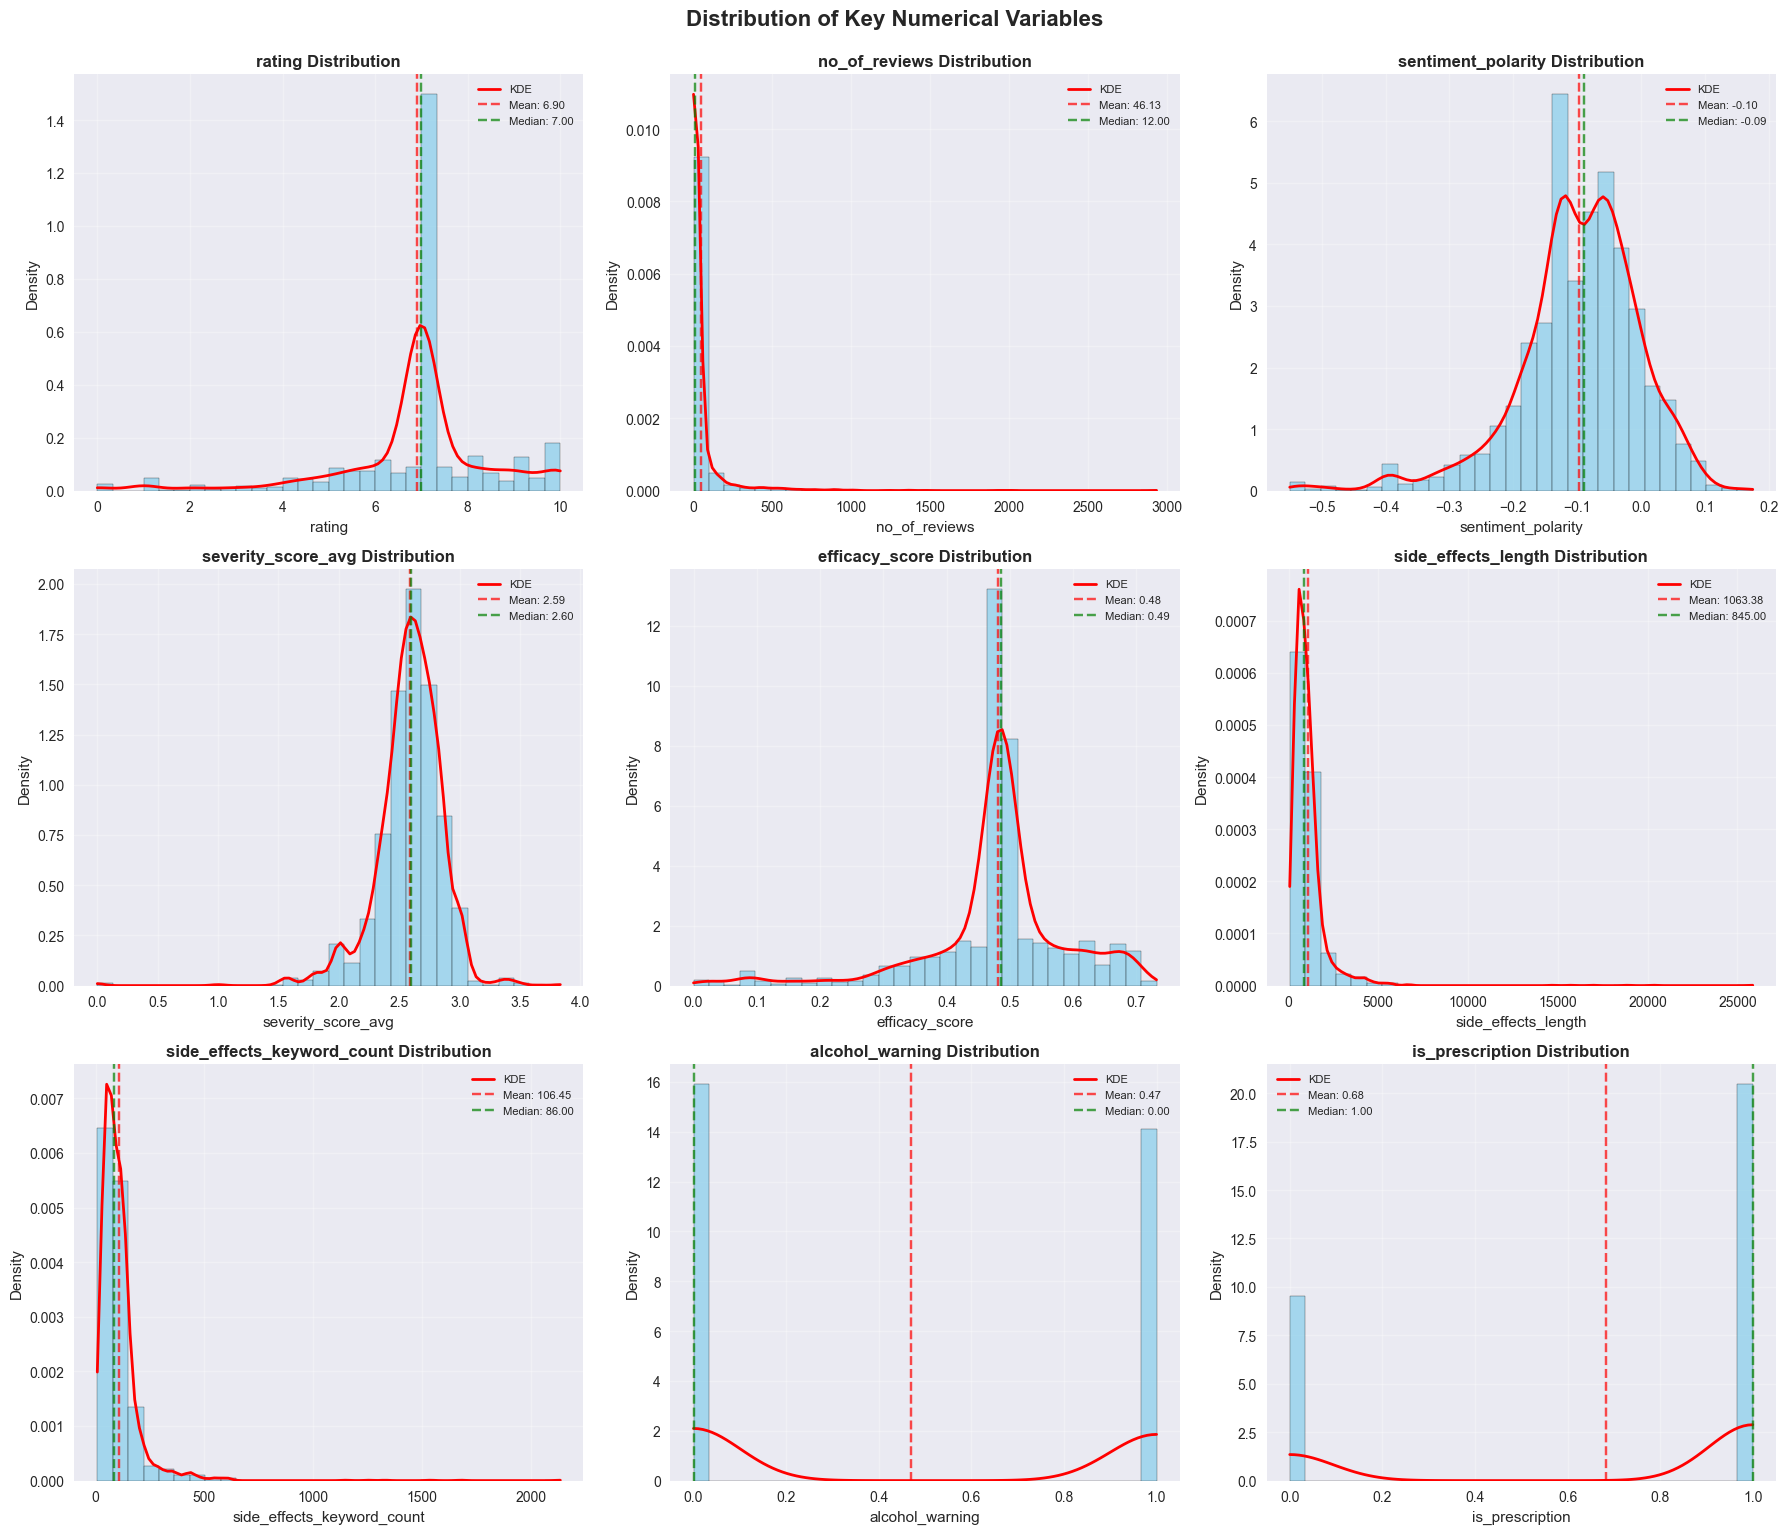


 STATISTICAL SUMMARY AND INSIGHTS:

 RATING ANALYSIS:
   Count: 2,931
   Mean: 6.899
   Median: 7.000
   Std Dev: 1.704
   Min: 0.000
   Max: 10.000
   Skewness: -1.256
   Kurtosis: 3.709
    Distribution: left-skewed (negatively skewed)
    Outliers: 1045 (35.7%)
      Range: [0.000, 10.000]

 NO_OF_REVIEWS ANALYSIS:
   Count: 2,931
   Mean: 46.125
   Median: 12.000
   Std Dev: 139.579
   Min: 1.000
   Max: 2934.000
   Skewness: 8.301
   Kurtosis: 107.378
    Distribution: right-skewed (positively skewed)
    Outliers: 1030 (35.1%)
      Range: [1.000, 2934.000]

 SENTIMENT_POLARITY ANALYSIS:
   Count: 2,931
   Mean: -0.097
   Median: -0.089
   Std Dev: 0.095
   Min: -0.550
   Max: 0.175
   Skewness: -1.004
   Kurtosis: 2.526
    Distribution: left-skewed (negatively skewed)
    Outliers: 119 (4.1%)
      Range: [-0.550, 0.175]

 SEVERITY_SCORE_AVG ANALYSIS:
   Count: 2,931
   Mean: 2.587
   Median: 2.600
   Std Dev: 0.279
   Min: 0.000
   Max: 3.833
   Skewness: -1.650
   Kurtosis: 

In [115]:
print("NUMERICAL VARIABLES DISTRIBUTION ANALYSIS")


# Key numerical columns to analyze
key_numeric_cols = []
for col in ['rating', 'no_of_reviews', 'sentiment_polarity', 'severity_score_avg', 'efficacy_score']:
    if col in df.columns:
        key_numeric_cols.append(col)

# Add other important numeric columns
additional_numeric = [col for col in numeric_cols if col not in key_numeric_cols][:6]
key_numeric_cols.extend(additional_numeric)

print(f"Analyzing {len(key_numeric_cols)} key numerical variables...")

# Create comprehensive distribution plots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.ravel()

for i, col in enumerate(key_numeric_cols[:9]):  # Show first 9 columns
    if i < len(axes):
        # Histogram with KDE overlay
        axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, color='skyblue', density=True, edgecolor='black')
        
        # Add KDE curve
        try:
            from scipy import stats
            kde_data = df[col].dropna()
            if len(kde_data) > 1 and kde_data.std() > 0:
                kde = stats.gaussian_kde(kde_data)
                x_range = np.linspace(kde_data.min(), kde_data.max(), 100)
                axes[i].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
        except:
            pass
        
        axes[i].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
        axes[i].grid(True, alpha=0.3)
        
        # Add statistics text
        mean_val = df[col].mean()
        median_val = df[col].median()
        std_val = df[col].std()
        axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='--', alpha=0.7, label=f'Median: {median_val:.2f}')
        axes[i].legend(fontsize=8)

plt.tight_layout()
plt.suptitle('Distribution of Key Numerical Variables', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Statistical summary with insights
print("\n STATISTICAL SUMMARY AND INSIGHTS:")

for col in key_numeric_cols[:6]:  # Focus on top 6 columns
    data = df[col].dropna()
    if len(data) > 0:
        print(f"\n {col.upper()} ANALYSIS:")
        print(f"   Count: {len(data):,}")
        print(f"   Mean: {data.mean():.3f}")
        print(f"   Median: {data.median():.3f}")
        print(f"   Std Dev: {data.std():.3f}")
        print(f"   Min: {data.min():.3f}")
        print(f"   Max: {data.max():.3f}")
        print(f"   Skewness: {data.skew():.3f}")
        print(f"   Kurtosis: {data.kurtosis():.3f}")
        
        # Distribution insights
        skew_val = data.skew()
        if abs(skew_val) < 0.5:
            skew_desc = "approximately symmetric"
        elif skew_val > 0:
            skew_desc = "right-skewed (positively skewed)"
        else:
            skew_desc = "left-skewed (negatively skewed)"
        
        print(f"    Distribution: {skew_desc}")
        
        # Outlier detection using IQR method
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        
        print(f"    Outliers: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)")
        
        if len(outliers) > 0:
            print(f"      Range: [{outliers.min():.3f}, {outliers.max():.3f}]")

print(f"\n NUMERICAL DISTRIBUTION ANALYSIS COMPLETE!")


CATEGORICAL VARIABLES ANALYSIS
Analyzing 8 key categorical variables...


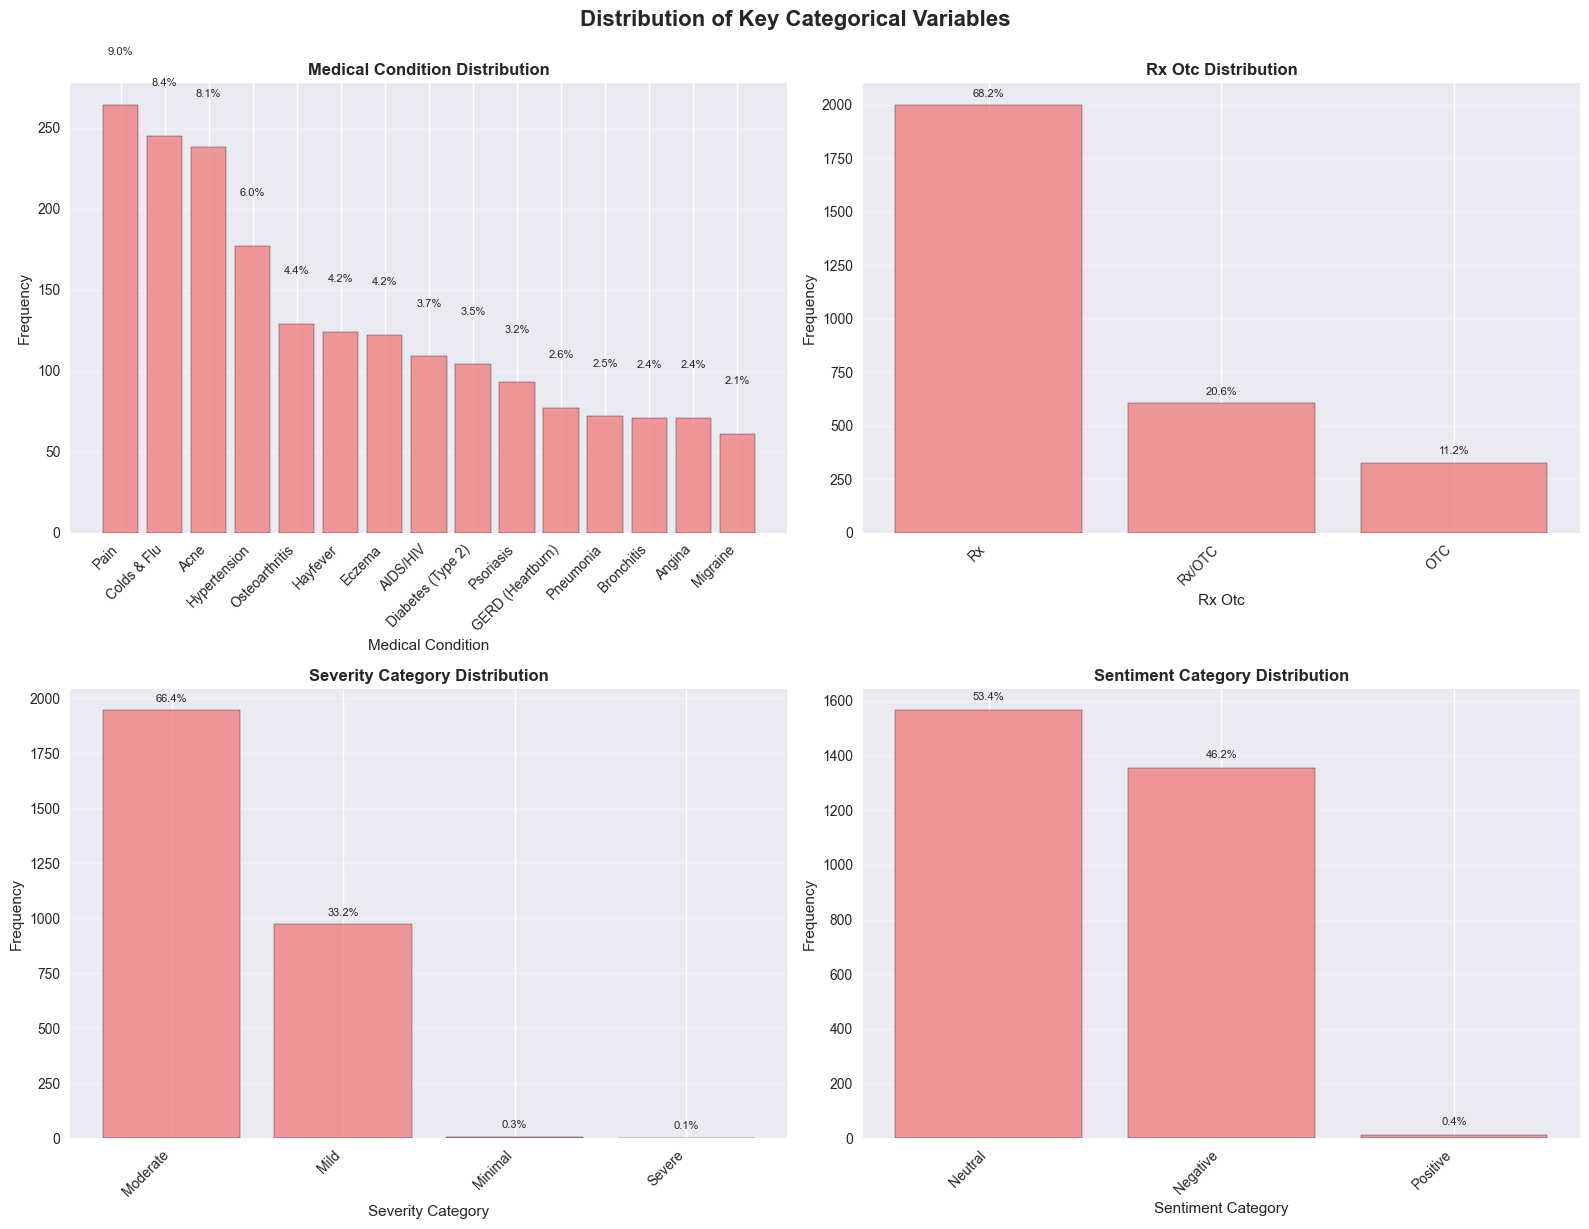


 CATEGORICAL ANALYSIS AND INSIGHTS:

 MEDICAL CONDITION ANALYSIS:
   Total unique values: 47
   Most common: 'Pain' (264 occurrences, 9.0%)
   Top 5 categories:
      1. Pain: 264 (9.0%)
      2. Colds & Flu: 245 (8.4%)
      3. Acne: 238 (8.1%)
      4. Hypertension: 177 (6.0%)
      5. Osteoarthritis: 129 (4.4%)
    Distribution: Medium cardinality (47 unique values)
    Concentration: Top 5 categories cover 35.9% of data
    Balance: Well balanced

 RX OTC ANALYSIS:
   Total unique values: 3
   Most common: 'Rx' (1,999 occurrences, 68.2%)
   Top 5 categories:
      1. Rx: 1,999 (68.2%)
      2. Rx/OTC: 604 (20.6%)
      3. OTC: 328 (11.2%)
    Distribution: Low cardinality (3 unique values)
    Concentration: Top 5 categories cover 100.0% of data
    Balance: Moderately imbalanced

 SEVERITY CATEGORY ANALYSIS:
   Total unique values: 4
   Most common: 'Moderate' (1,946 occurrences, 66.4%)
   Top 5 categories:
      1. Moderate: 1,946 (66.4%)
      2. Mild: 974 (33.2%)
      3. Mini

In [116]:
print("CATEGORICAL VARIABLES ANALYSIS")


# Key categorical columns to analyze
key_categorical_cols = []
for col in ['medical_condition', 'rx_otc', 'severity_category', 'sentiment_category']:
    if col in df.columns:
        key_categorical_cols.append(col)

# Add other categorical columns
additional_categorical = [col for col in categorical_cols if col not in key_categorical_cols and col != 'drug_name'][:4]
key_categorical_cols.extend(additional_categorical)

print(f"Analyzing {len(key_categorical_cols)} key categorical variables...")

# Create comprehensive categorical analysis
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(key_categorical_cols[:4]):  # Show first 4 columns
    if i < len(axes):
        # Value counts
        value_counts = df[col].value_counts()
        
        # Show top 15 categories to avoid overcrowding
        top_categories = value_counts.head(15)
        
        # Create bar plot
        bars = axes[i].bar(range(len(top_categories)), top_categories.values, 
                          color='lightcoral', alpha=0.8, edgecolor='black')
        
        axes[i].set_title(f'{col.replace("_", " ").title()} Distribution', 
                         fontsize=12, fontweight='bold')
        axes[i].set_xlabel(col.replace("_", " ").title())
        axes[i].set_ylabel('Frequency')
        axes[i].set_xticks(range(len(top_categories)))
        axes[i].set_xticklabels(top_categories.index, rotation=45, ha='right')
        axes[i].grid(True, alpha=0.3, axis='y')
        
        # Add percentage labels on bars
        total = value_counts.sum()
        for j, bar in enumerate(bars):
            height = bar.get_height()
            percentage = (height / total) * 100
            axes[i].text(bar.get_x() + bar.get_width()/2., height + total*0.01,
                        f'{percentage:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.suptitle('Distribution of Key Categorical Variables', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Detailed categorical analysis with insights
print("\n CATEGORICAL ANALYSIS AND INSIGHTS:")


for col in key_categorical_cols:
    if col in df.columns:
        print(f"\n {col.upper().replace('_', ' ')} ANALYSIS:")
        
        value_counts = df[col].value_counts()
        unique_count = df[col].nunique()
        most_common = value_counts.index[0]
        most_common_count = value_counts.iloc[0]
        most_common_pct = (most_common_count / len(df)) * 100
        
        print(f"   Total unique values: {unique_count:,}")
        print(f"   Most common: '{most_common}' ({most_common_count:,} occurrences, {most_common_pct:.1f}%)")
        
        # Show top 5 categories
        print(f"   Top 5 categories:")
        for i, (category, count) in enumerate(value_counts.head(5).items(), 1):
            percentage = (count / len(df)) * 100
            print(f"      {i}. {category}: {count:,} ({percentage:.1f}%)")
        
        # Distribution insights
        if unique_count == 1:
            print(f"    Distribution: Constant (only one unique value)")
        elif unique_count < 10:
            print(f"    Distribution: Low cardinality ({unique_count} unique values)")
        elif unique_count < 50:
            print(f"    Distribution: Medium cardinality ({unique_count} unique values)")
        else:
            print(f"    Distribution: High cardinality ({unique_count} unique values)")
        
        # Concentration analysis
        top_5_pct = (value_counts.head(5).sum() / len(df)) * 100
        print(f"    Concentration: Top 5 categories cover {top_5_pct:.1f}% of data")
        
        # Balance analysis
        if most_common_pct > 70:
            balance_desc = "Highly imbalanced (one category dominates)"
        elif most_common_pct > 50:
            balance_desc = "Moderately imbalanced"
        elif most_common_pct > 30:
            balance_desc = "Fairly balanced"
        else:
            balance_desc = "Well balanced"
        
        print(f"    Balance: {balance_desc}")

print(f"\n CATEGORICAL ANALYSIS COMPLETE!")


 OUTLIER DETECTION AND BOX PLOT ANALYSIS
Analyzing outliers in 9 numerical variables...


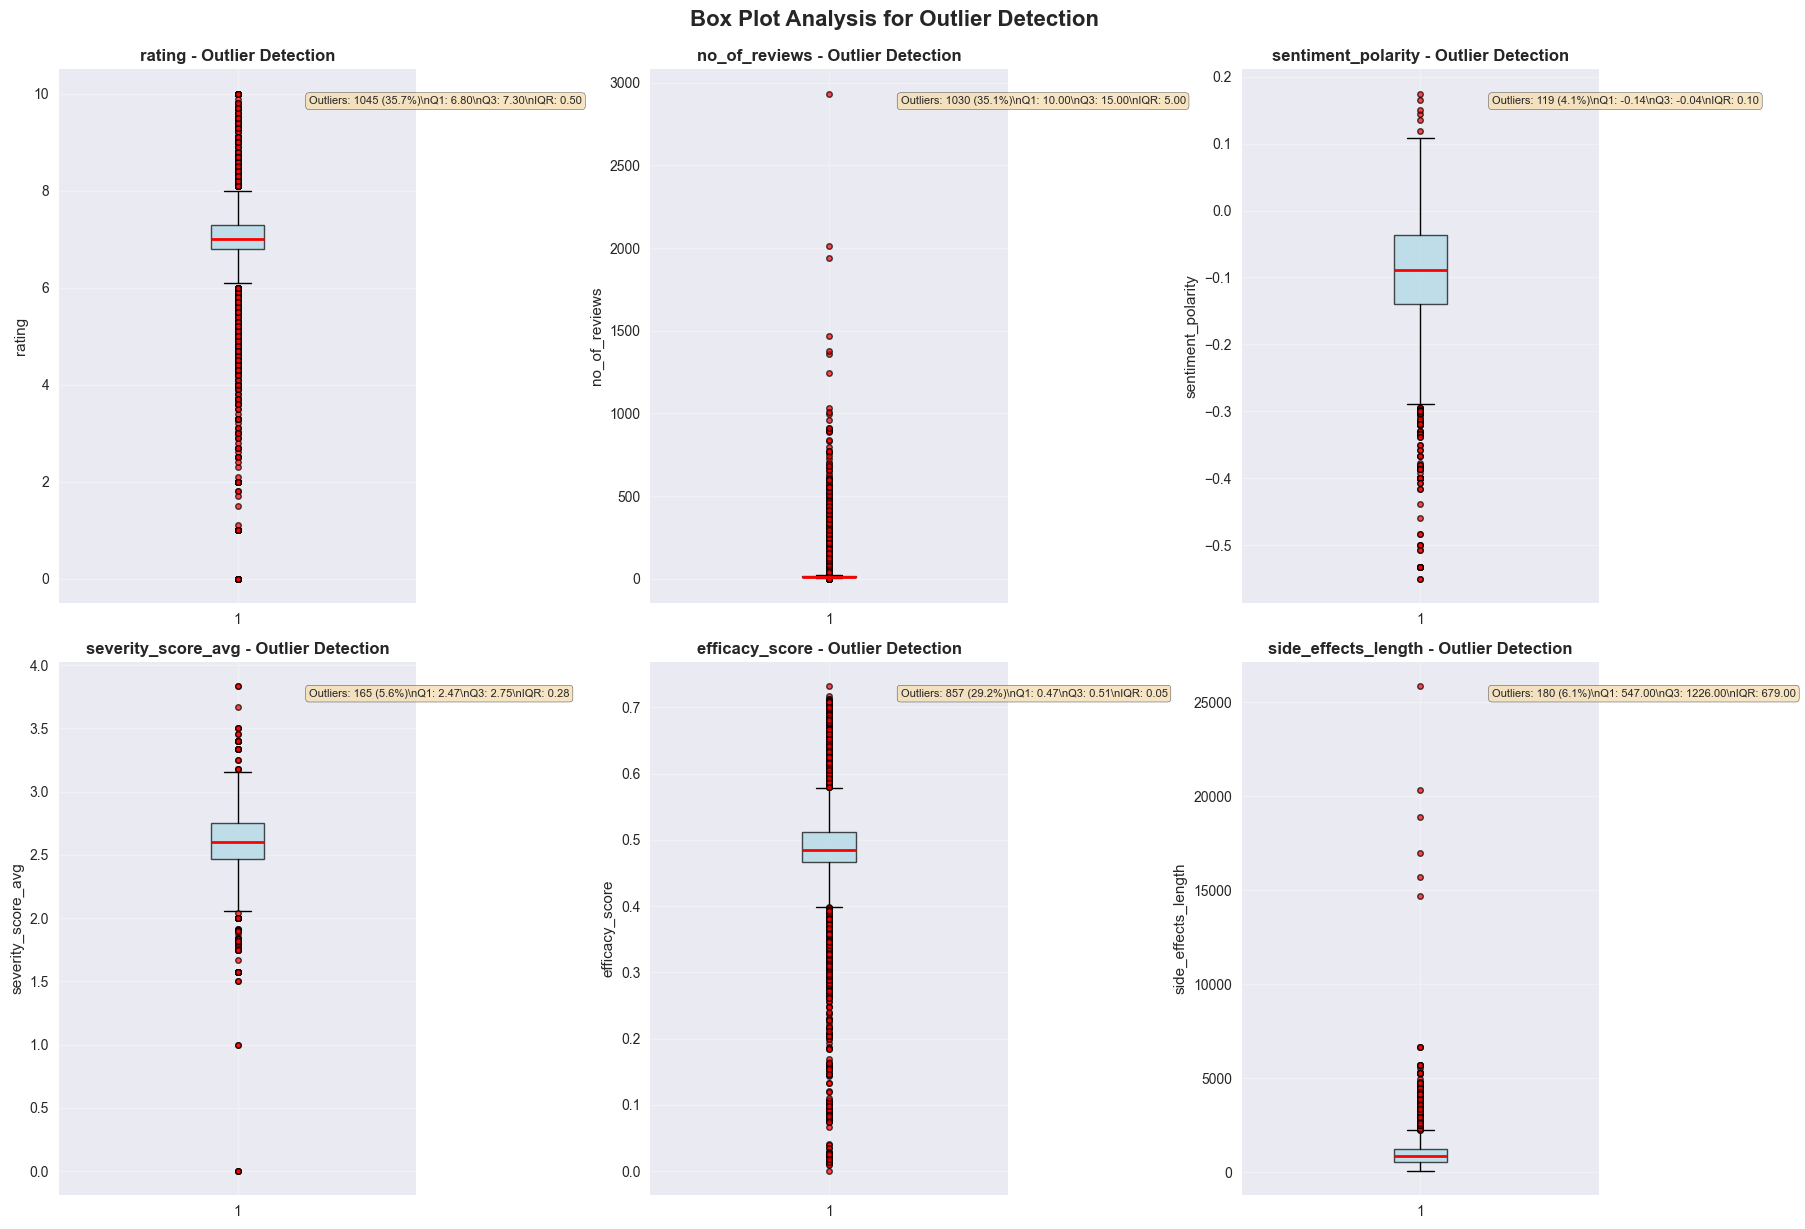

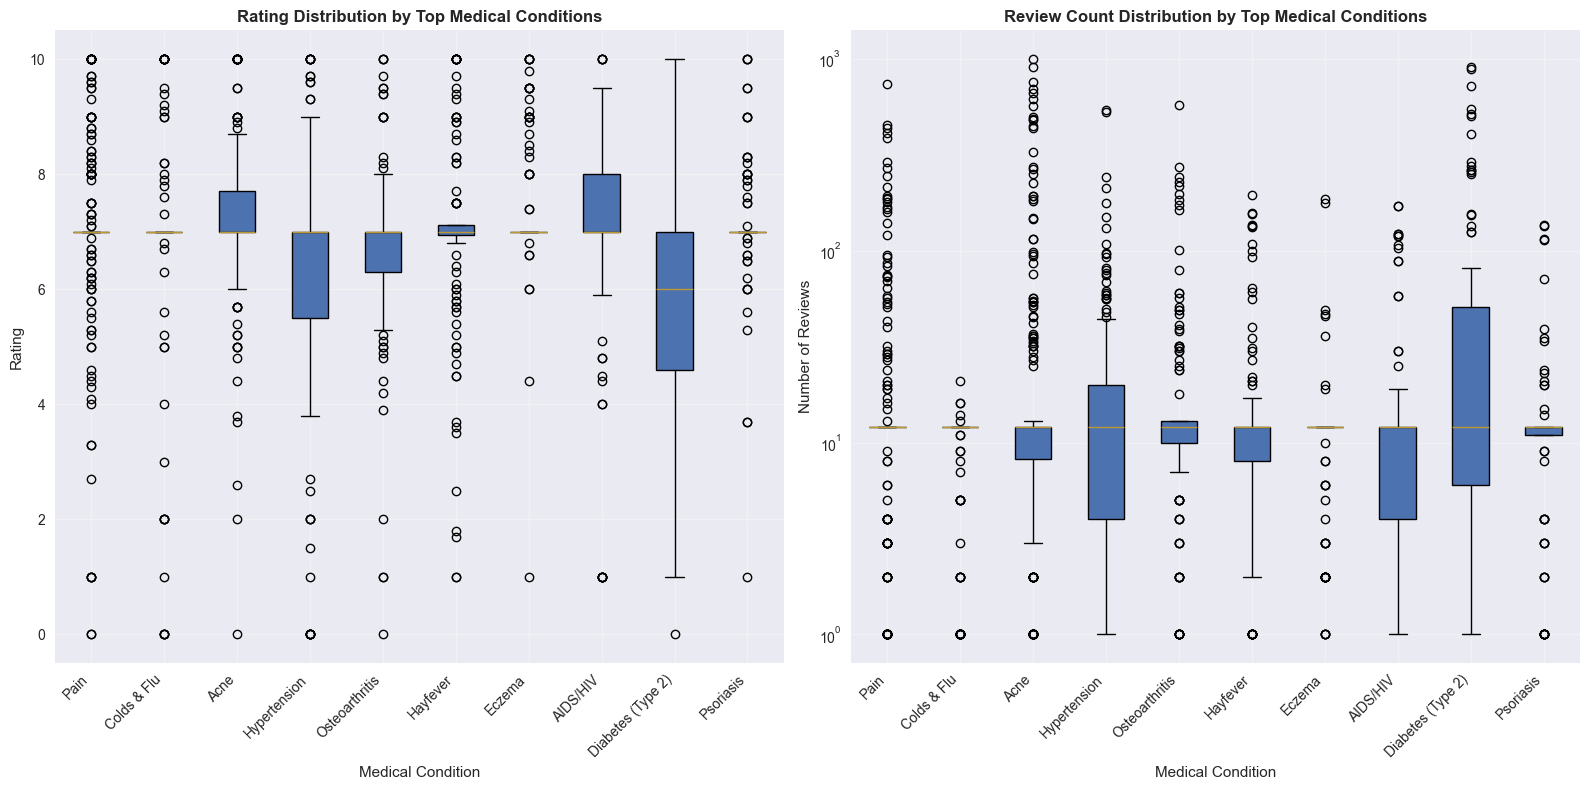


 DETAILED OUTLIER ANALYSIS AND INSIGHTS:

 RATING OUTLIER ANALYSIS:
   Total outliers: 1,045 (35.65%)
   IQR: 0.500
   Lower bound: 6.050
   Upper bound: 8.050
   Outlier range: [0.000, 10.000]
    Outlier severity: Very high (> 20%)
    Recommendation: Consider outlier treatment (capping, transformation, or removal)

 NO_OF_REVIEWS OUTLIER ANALYSIS:
   Total outliers: 1,030 (35.14%)
   IQR: 5.000
   Lower bound: 2.500
   Upper bound: 22.500
   Outlier range: [1.000, 2934.000]
    Outlier severity: Very high (> 20%)
    Recommendation: Consider outlier treatment (capping, transformation, or removal)

 SENTIMENT_POLARITY OUTLIER ANALYSIS:
   Total outliers: 119 (4.06%)
   IQR: 0.103
   Lower bound: -0.294
   Upper bound: 0.117
   Outlier range: [-0.550, 0.175]
    Outlier severity: Low (1-5%)
    Recommendation: Outliers are within acceptable range

 SEVERITY_SCORE_AVG OUTLIER ANALYSIS:
   Total outliers: 165 (5.63%)
   IQR: 0.283
   Lower bound: 2.042
   Upper bound: 3.175
   Outlier 

In [117]:
print(" OUTLIER DETECTION AND BOX PLOT ANALYSIS")

# Select key numerical columns for outlier analysis
outlier_cols = []
for col in ['rating', 'no_of_reviews', 'sentiment_polarity', 'severity_score_avg', 'efficacy_score']:
    if col in df.columns:
        outlier_cols.append(col)

# Add additional numeric columns
additional_numeric = [col for col in numeric_cols if col not in outlier_cols][:4]
outlier_cols.extend(additional_numeric)

print(f"Analyzing outliers in {len(outlier_cols)} numerical variables...")

# Create comprehensive box plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.ravel()

outlier_summary = {}

for i, col in enumerate(outlier_cols[:6]):  # Show first 6 columns
    if i < len(axes):
        # Box plot
        box_plot = axes[i].boxplot(df[col].dropna(), patch_artist=True, 
                                  boxprops=dict(facecolor='lightblue', alpha=0.7),
                                  medianprops=dict(color='red', linewidth=2),
                                  flierprops=dict(marker='o', markerfacecolor='red', 
                                                 markersize=4, alpha=0.7))
        
        axes[i].set_title(f'{col} - Outlier Detection', fontsize=12, fontweight='bold')
        axes[i].set_ylabel(col)
        axes[i].grid(True, alpha=0.3)
        
        # Calculate outlier statistics
        data = df[col].dropna()
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(data)) * 100
        
        # Store outlier summary
        outlier_summary[col] = {
            'count': outlier_count,
            'percentage': outlier_percentage,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'median': data.median(),
            'min_outlier': outliers.min() if len(outliers) > 0 else None,
            'max_outlier': outliers.max() if len(outliers) > 0 else None
        }
        
        # Add statistics to plot
        stats_text = f'Outliers: {outlier_count} ({outlier_percentage:.1f}%)\\nQ1: {Q1:.2f}\\nQ3: {Q3:.2f}\\nIQR: {IQR:.2f}'
        axes[i].text(0.7, 0.95, stats_text, transform=axes[i].transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                    fontsize=8)

plt.tight_layout()
plt.suptitle('Box Plot Analysis for Outlier Detection', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Create comparative box plots by categorical variables
if 'medical_condition' in df.columns:
    # Box plots by medical condition for rating
    plt.figure(figsize=(16, 8))
    
    # Select top 10 medical conditions
    top_conditions = df['medical_condition'].value_counts().head(10).index
    condition_data = df[df['medical_condition'].isin(top_conditions)]
    
    plt.subplot(1, 2, 1)
    box_data = [condition_data[condition_data['medical_condition'] == condition]['rating'].dropna() 
                for condition in top_conditions]
    plt.boxplot(box_data, labels=top_conditions, patch_artist=True)
    plt.title('Rating Distribution by Top Medical Conditions', fontsize=12, fontweight='bold')
    plt.xlabel('Medical Condition')
    plt.ylabel('Rating')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # Box plots by medical condition for number of reviews
    plt.subplot(1, 2, 2)
    box_data_reviews = [condition_data[condition_data['medical_condition'] == condition]['no_of_reviews'].dropna() 
                       for condition in top_conditions]
    plt.boxplot(box_data_reviews, labels=top_conditions, patch_artist=True)
    plt.title('Review Count Distribution by Top Medical Conditions', fontsize=12, fontweight='bold')
    plt.xlabel('Medical Condition')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45, ha='right')
    plt.yscale('log')  # Log scale for better visibility
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Detailed outlier analysis and insights
print("\n DETAILED OUTLIER ANALYSIS AND INSIGHTS:")


for col, stats in outlier_summary.items():
    print(f"\n {col.upper()} OUTLIER ANALYSIS:")
    print(f"   Total outliers: {stats['count']:,} ({stats['percentage']:.2f}%)")
    print(f"   IQR: {stats['IQR']:.3f}")
    print(f"   Lower bound: {stats['lower_bound']:.3f}")
    print(f"   Upper bound: {stats['upper_bound']:.3f}")
    
    if stats['min_outlier'] is not None:
        print(f"   Outlier range: [{stats['min_outlier']:.3f}, {stats['max_outlier']:.3f}]")
    
    # Outlier severity assessment
    if stats['percentage'] < 1:
        severity = "Very low (< 1%)"
    elif stats['percentage'] < 5:
        severity = "Low (1-5%)"
    elif stats['percentage'] < 10:
        severity = "Moderate (5-10%)"
    elif stats['percentage'] < 20:
        severity = "High (10-20%)"
    else:
        severity = "Very high (> 20%)"
    
    print(f"    Outlier severity: {severity}")
    
    # Recommendations
    if stats['percentage'] > 10:
        print(f"    Recommendation: Consider outlier treatment (capping, transformation, or removal)")
    elif stats['percentage'] > 5:
        print(f"    Recommendation: Monitor these outliers, may need investigation")
    else:
        print(f"    Recommendation: Outliers are within acceptable range")

print(f"\n OUTLIER ANALYSIS COMPLETE!")


 CORRELATION ANALYSIS AND FEATURE RELATIONSHIPS
Analyzing correlations among 64 numerical variables...


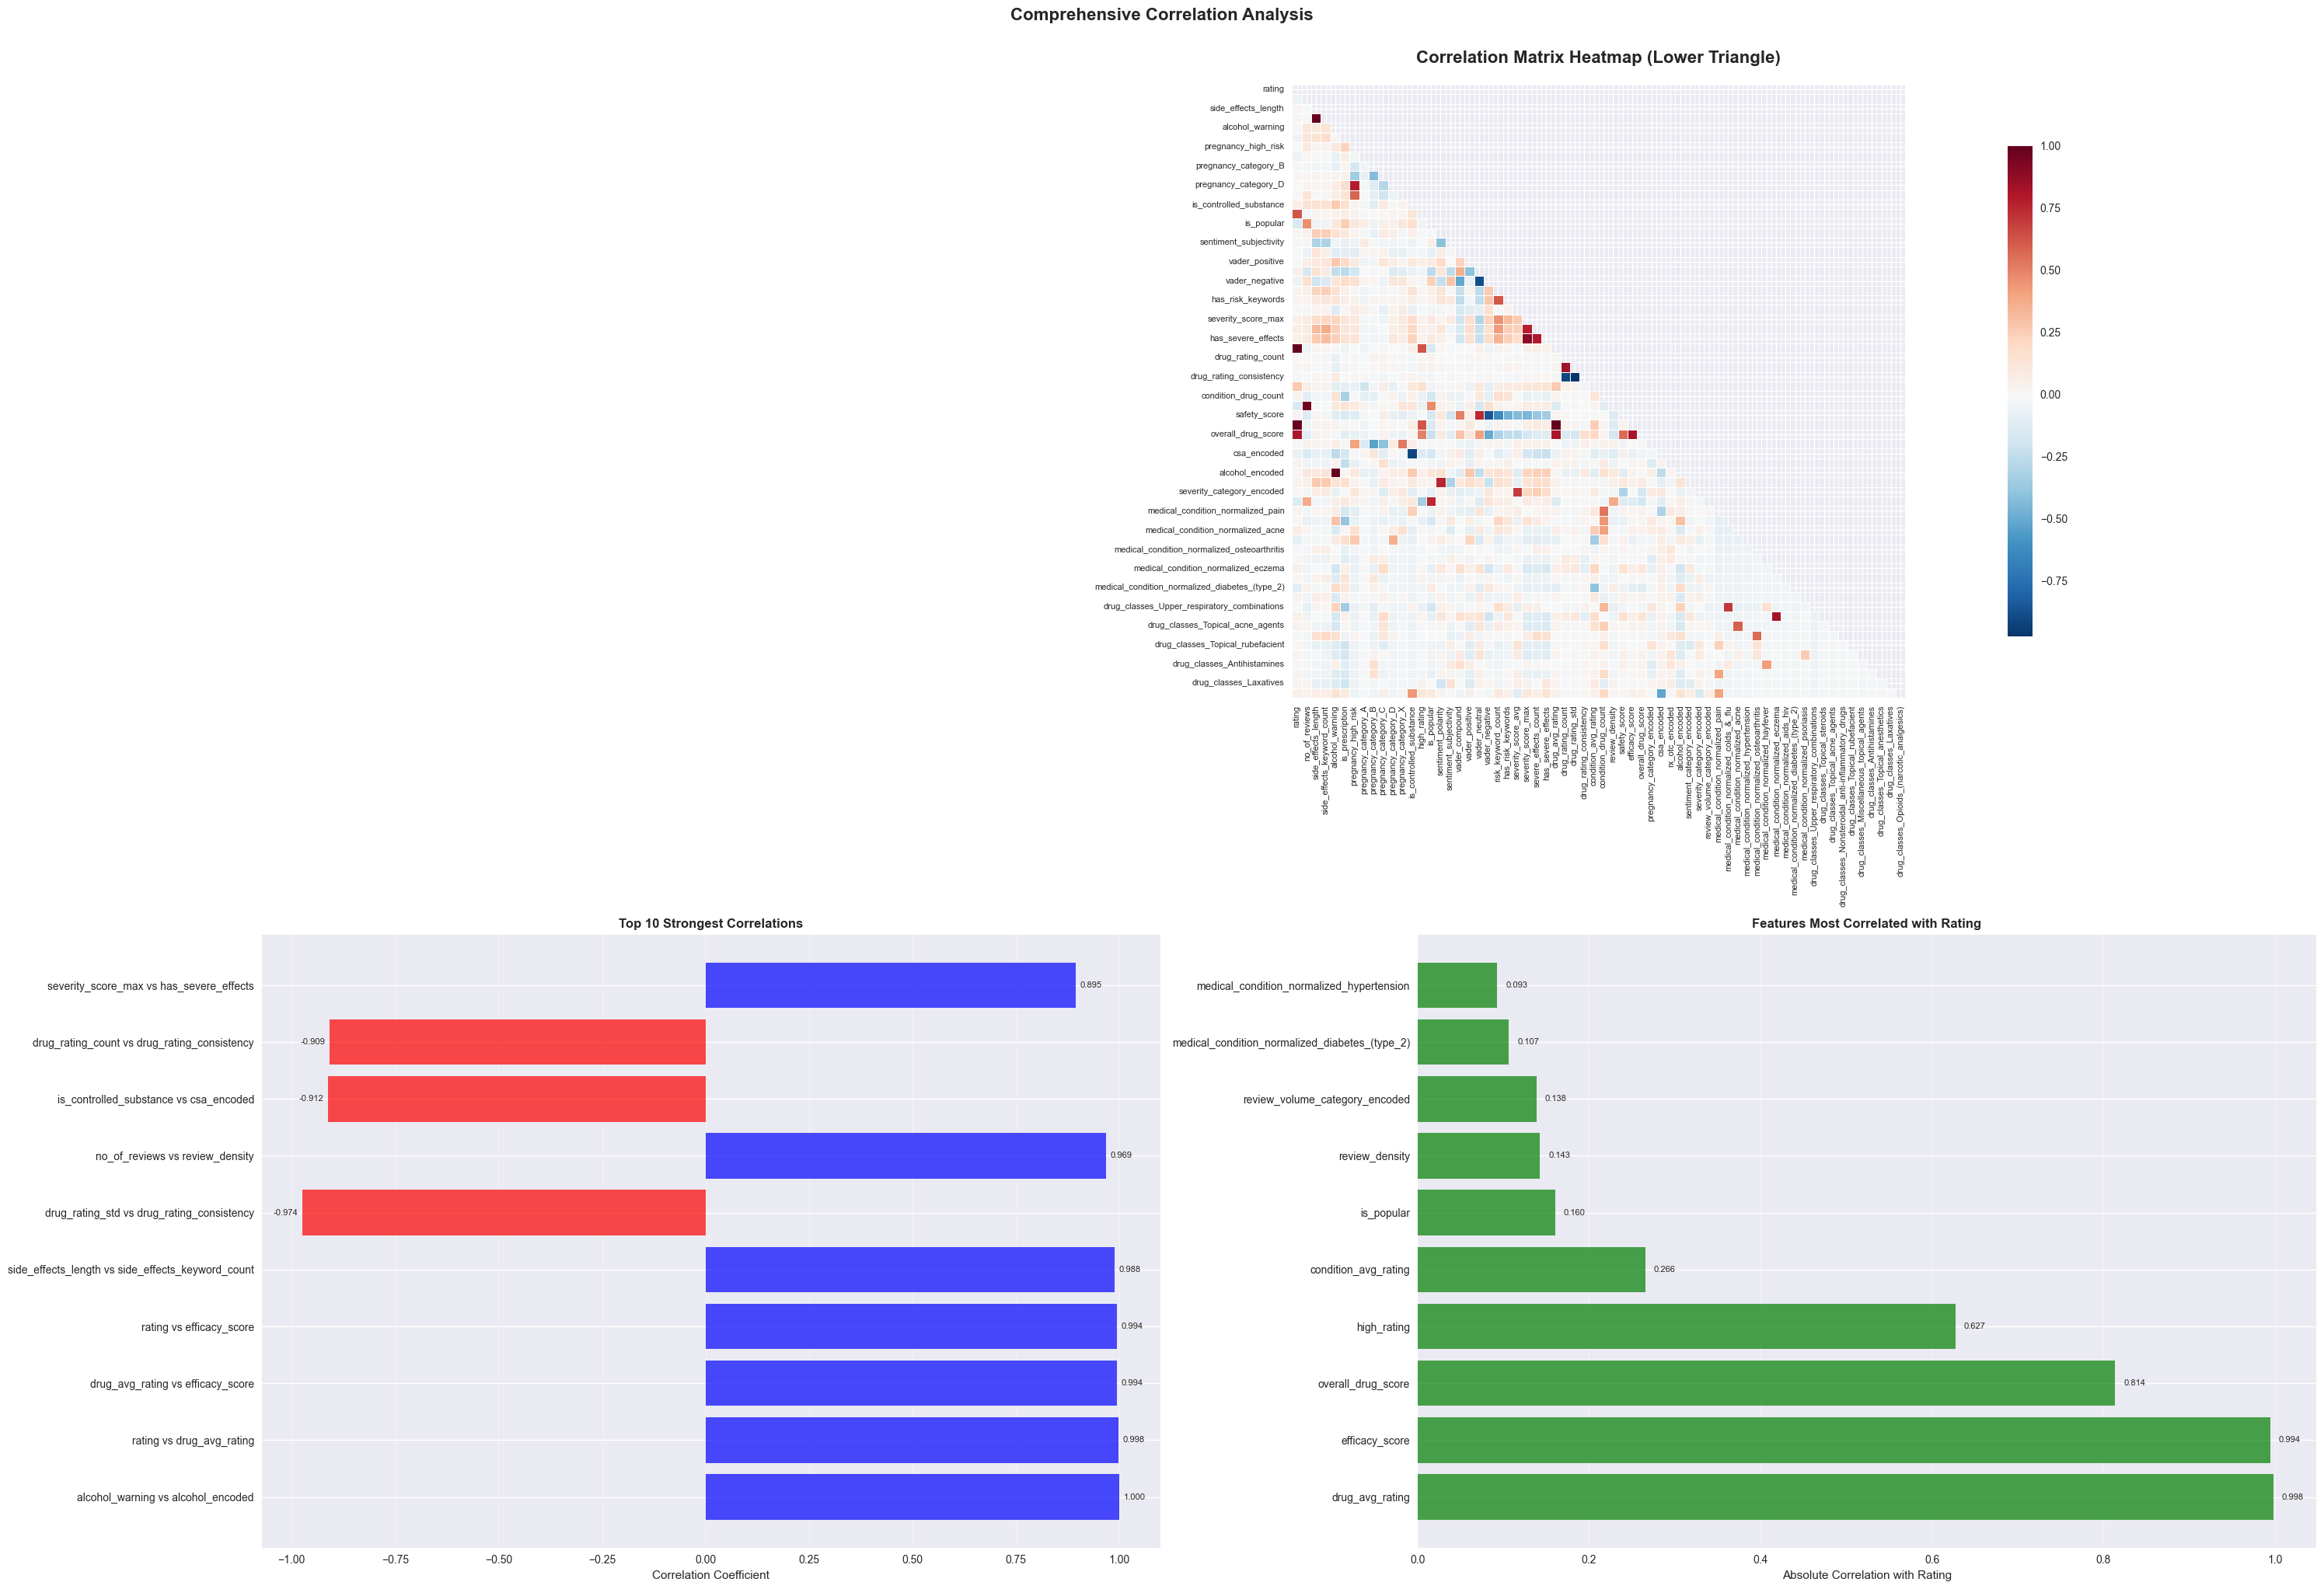

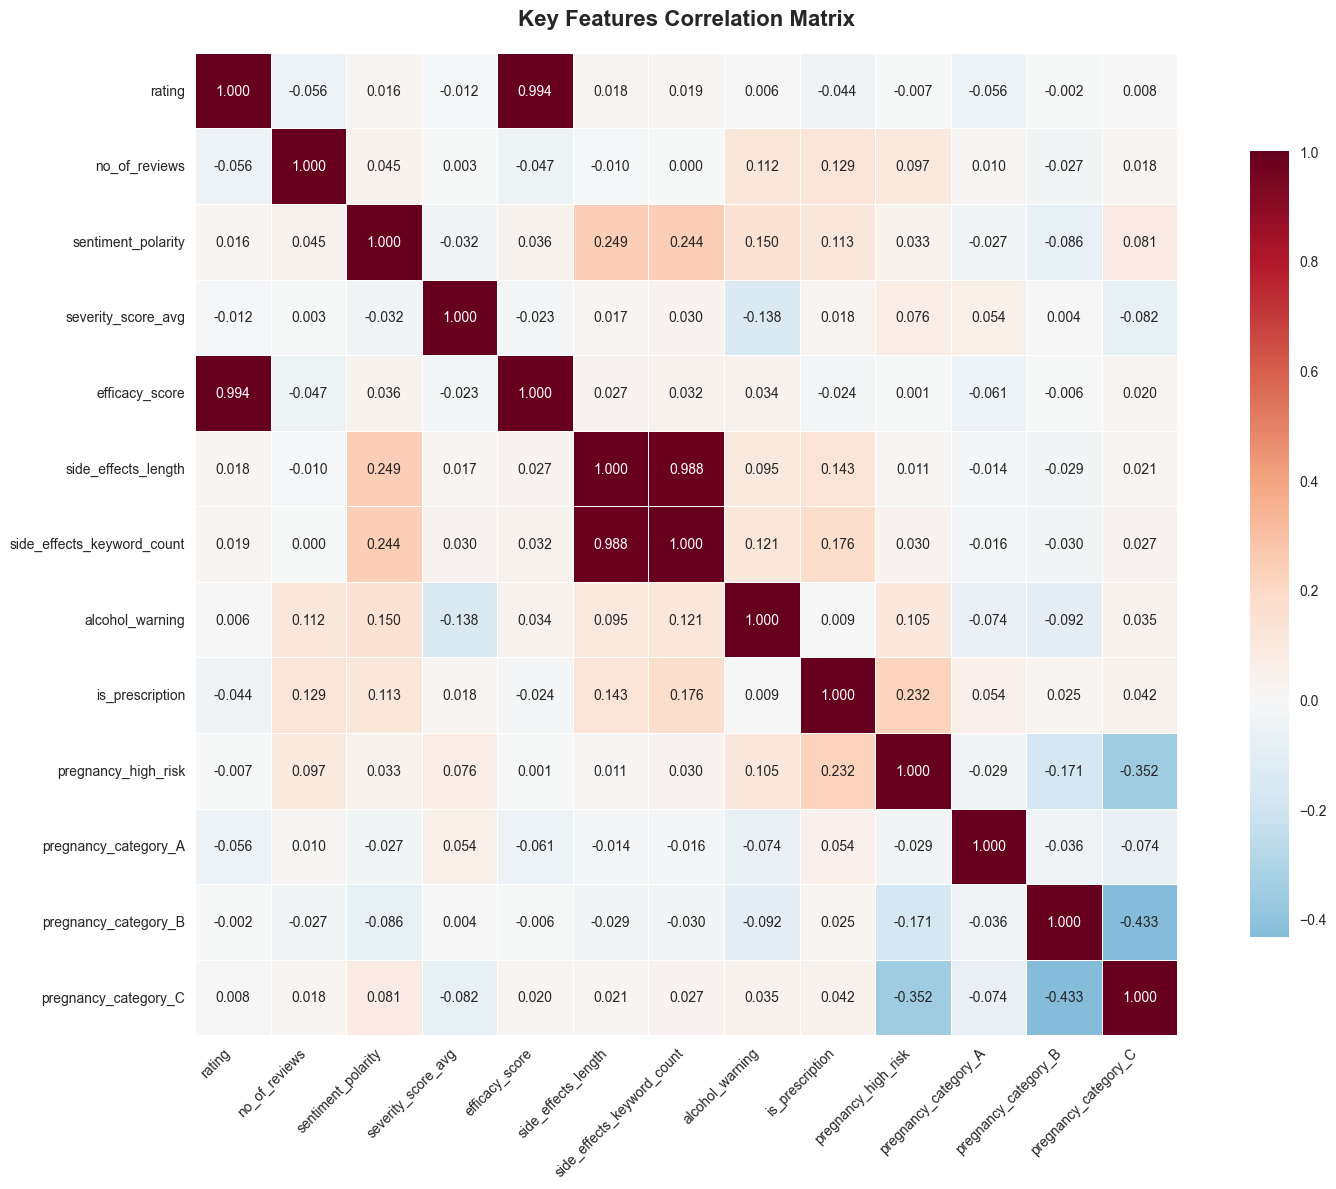


 DETAILED CORRELATION INSIGHTS:

 CORRELATION STATISTICS:
   Total correlation pairs: 2,016
   Mean absolute correlation: 0.083
   Median absolute correlation: 0.045
   Max correlation: 1.000
   Min correlation: -0.974

 CORRELATION STRENGTH DISTRIBUTION:
   Strong positive (≥0.7): 18 (0.9%)
   Moderate positive (0.3-0.7): 36 (1.8%)
   Weak positive (0.1-0.3): 222 (11.0%)
   Weak negative (-0.3 to -0.1): 168 (8.3%)
   Moderate negative (-0.7 to -0.3): 28 (1.4%)
   Strong negative (≤-0.7): 5 (0.2%)

 TOP CORRELATIONS (|r| ≥ 0.3):
   1. alcohol_warning ↔ alcohol_encoded: 1.000 (Strong positive)
   2. rating ↔ drug_avg_rating: 0.998 (Strong positive)
   3. drug_avg_rating ↔ efficacy_score: 0.994 (Strong positive)
   4. rating ↔ efficacy_score: 0.994 (Strong positive)
   5. side_effects_length ↔ side_effects_keyword_count: 0.988 (Strong positive)
   6. drug_rating_std ↔ drug_rating_consistency: -0.974 (Strong negative)
   7. no_of_reviews ↔ review_density: 0.969 (Strong positive)
   8. is

In [118]:
print(" CORRELATION ANALYSIS AND FEATURE RELATIONSHIPS")


# Select numerical columns for correlation analysis
corr_cols = [col for col in numeric_cols if df[col].nunique() > 1]  # Exclude constant columns
print(f"Analyzing correlations among {len(corr_cols)} numerical variables...")

# Calculate correlation matrix
correlation_matrix = df[corr_cols].corr()

# Create comprehensive correlation heatmap
plt.figure(figsize=(30, 20))

# Main correlation heatmap
plt.subplot(2, 2, (1, 2))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(
    correlation_matrix, mask=mask, annot=False, cmap='RdBu_r', center=0,
    square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}
)

plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8, rotation=0)
plt.title('Correlation Matrix Heatmap (Lower Triangle)', fontsize=16, fontweight='bold', pad=20)

# Strongest correlations subplot
plt.subplot(2, 2, 3)
# Get upper triangle correlations
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
strong_correlations = []

for i in range(len(upper_tri.columns)):
    for j in range(len(upper_tri.columns)):
        if not pd.isna(upper_tri.iloc[i, j]) and abs(upper_tri.iloc[i, j]) >= 0.3:
            strong_correlations.append({
                'Feature 1': upper_tri.columns[i],
                'Feature 2': upper_tri.columns[j],
                'Correlation': upper_tri.iloc[i, j]
            })

if strong_correlations:
    strong_df = pd.DataFrame(strong_correlations).sort_values('Correlation', key=abs, ascending=False)
    top_10_strong = strong_df.head(10)
    
    bars = plt.barh(range(len(top_10_strong)), top_10_strong['Correlation'], 
                   color=['red' if x < 0 else 'blue' for x in top_10_strong['Correlation']], alpha=0.7)
    plt.yticks(range(len(top_10_strong)), 
              [f"{row['Feature 1']} vs {row['Feature 2']}" for _, row in top_10_strong.iterrows()])
    plt.xlabel('Correlation Coefficient')
    plt.title('Top 10 Strongest Correlations', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add correlation values on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + (0.01 if width > 0 else -0.01), bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left' if width > 0 else 'right', va='center', fontsize=8)

# Correlation with target variable (rating) if available
plt.subplot(2, 2, 4)
if 'rating' in df.columns:
    rating_correlations = correlation_matrix['rating'].drop('rating').abs().sort_values(ascending=False)
    top_rating_corr = rating_correlations.head(10)
    
    bars = plt.barh(range(len(top_rating_corr)), top_rating_corr.values, 
                   color='green', alpha=0.7)
    plt.yticks(range(len(top_rating_corr)), top_rating_corr.index)
    plt.xlabel('Absolute Correlation with Rating')
    plt.title('Features Most Correlated with Rating', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add correlation values on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.suptitle('Comprehensive Correlation Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Create a focused heatmap for key features
key_features = []
for feature in ['rating', 'no_of_reviews', 'sentiment_polarity', 'severity_score_avg', 'efficacy_score']:
    if feature in df.columns:
        key_features.append(feature)

# Add other important features
additional_features = [col for col in corr_cols if col not in key_features][:8]
key_features.extend(additional_features)

if len(key_features) > 1:
    plt.figure(figsize=(16, 12))
    key_corr_matrix = df[key_features].corr()
    
    # Create annotated heatmap
    sns.heatmap(key_corr_matrix, annot=True, cmap='RdBu_r', center=0,
               square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.3f',
               annot_kws={'size': 10}, xticklabels=True, yticklabels=True)
    plt.title('Key Features Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

# Detailed correlation insights
print("\n DETAILED CORRELATION INSIGHTS:")


# Overall correlation statistics
all_correlations = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
all_correlations = all_correlations[~np.isnan(all_correlations)]

print(f"\n CORRELATION STATISTICS:")
print(f"   Total correlation pairs: {len(all_correlations):,}")
print(f"   Mean absolute correlation: {np.mean(np.abs(all_correlations)):.3f}")
print(f"   Median absolute correlation: {np.median(np.abs(all_correlations)):.3f}")
print(f"   Max correlation: {np.max(all_correlations):.3f}")
print(f"   Min correlation: {np.min(all_correlations):.3f}")

# Correlation strength distribution
strong_positive = sum(1 for x in all_correlations if x >= 0.7)
moderate_positive = sum(1 for x in all_correlations if 0.3 <= x < 0.7)
weak_positive = sum(1 for x in all_correlations if 0.1 <= x < 0.3)
weak_negative = sum(1 for x in all_correlations if -0.3 < x <= -0.1)
moderate_negative = sum(1 for x in all_correlations if -0.7 < x <= -0.3)
strong_negative = sum(1 for x in all_correlations if x <= -0.7)

print(f"\n CORRELATION STRENGTH DISTRIBUTION:")
print(f"   Strong positive (≥0.7): {strong_positive} ({strong_positive/len(all_correlations)*100:.1f}%)")
print(f"   Moderate positive (0.3-0.7): {moderate_positive} ({moderate_positive/len(all_correlations)*100:.1f}%)")
print(f"   Weak positive (0.1-0.3): {weak_positive} ({weak_positive/len(all_correlations)*100:.1f}%)")
print(f"   Weak negative (-0.3 to -0.1): {weak_negative} ({weak_negative/len(all_correlations)*100:.1f}%)")
print(f"   Moderate negative (-0.7 to -0.3): {moderate_negative} ({moderate_negative/len(all_correlations)*100:.1f}%)")
print(f"   Strong negative (≤-0.7): {strong_negative} ({strong_negative/len(all_correlations)*100:.1f}%)")

# Top correlations analysis
if strong_correlations:
    print(f"\n TOP CORRELATIONS (|r| ≥ 0.3):")
    for i, corr in enumerate(strong_df.head(10).iterrows(), 1):
        row = corr[1]
        strength = "Strong" if abs(row['Correlation']) >= 0.7 else "Moderate"
        direction = "positive" if row['Correlation'] > 0 else "negative"
        print(f"   {i}. {row['Feature 1']} ↔ {row['Feature 2']}: {row['Correlation']:.3f} ({strength} {direction})")

# Rating correlations analysis
if 'rating' in df.columns:
    print(f"\n RATING CORRELATIONS:")
    rating_corr = correlation_matrix['rating'].drop('rating').sort_values(key=abs, ascending=False)
    print(f"   Most positively correlated with rating:")
    positive_rating = rating_corr[rating_corr > 0].head(3)
    for feature, corr in positive_rating.items():
        print(f"      • {feature}: {corr:.3f}")
    
    print(f"   Most negatively correlated with rating:")
    negative_rating = rating_corr[rating_corr < 0].head(3)
    for feature, corr in negative_rating.items():
        print(f"      • {feature}: {corr:.3f}")

# Multicollinearity warning
high_corr_pairs = [(name1, name2, corr) for name1, name2, corr in 
                   [(strong_df.iloc[i]['Feature 1'], strong_df.iloc[i]['Feature 2'], strong_df.iloc[i]['Correlation']) 
                    for i in range(min(len(strong_df), 10))] if abs(corr) >= 0.8]

if high_corr_pairs:
    print(f"\n MULTICOLLINEARITY WARNING:")
    print(f"   {len(high_corr_pairs)} feature pairs have very high correlation (≥0.8):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"      • {feat1} ↔ {feat2}: {corr:.3f}")
    print(f"    Consider feature selection or dimensionality reduction for ML models")

print(f"\n CORRELATION ANALYSIS COMPLETE!")


CREATING CORRELATION VISUALIZATIONS
Selected 18 most important features for detailed correlation analysis


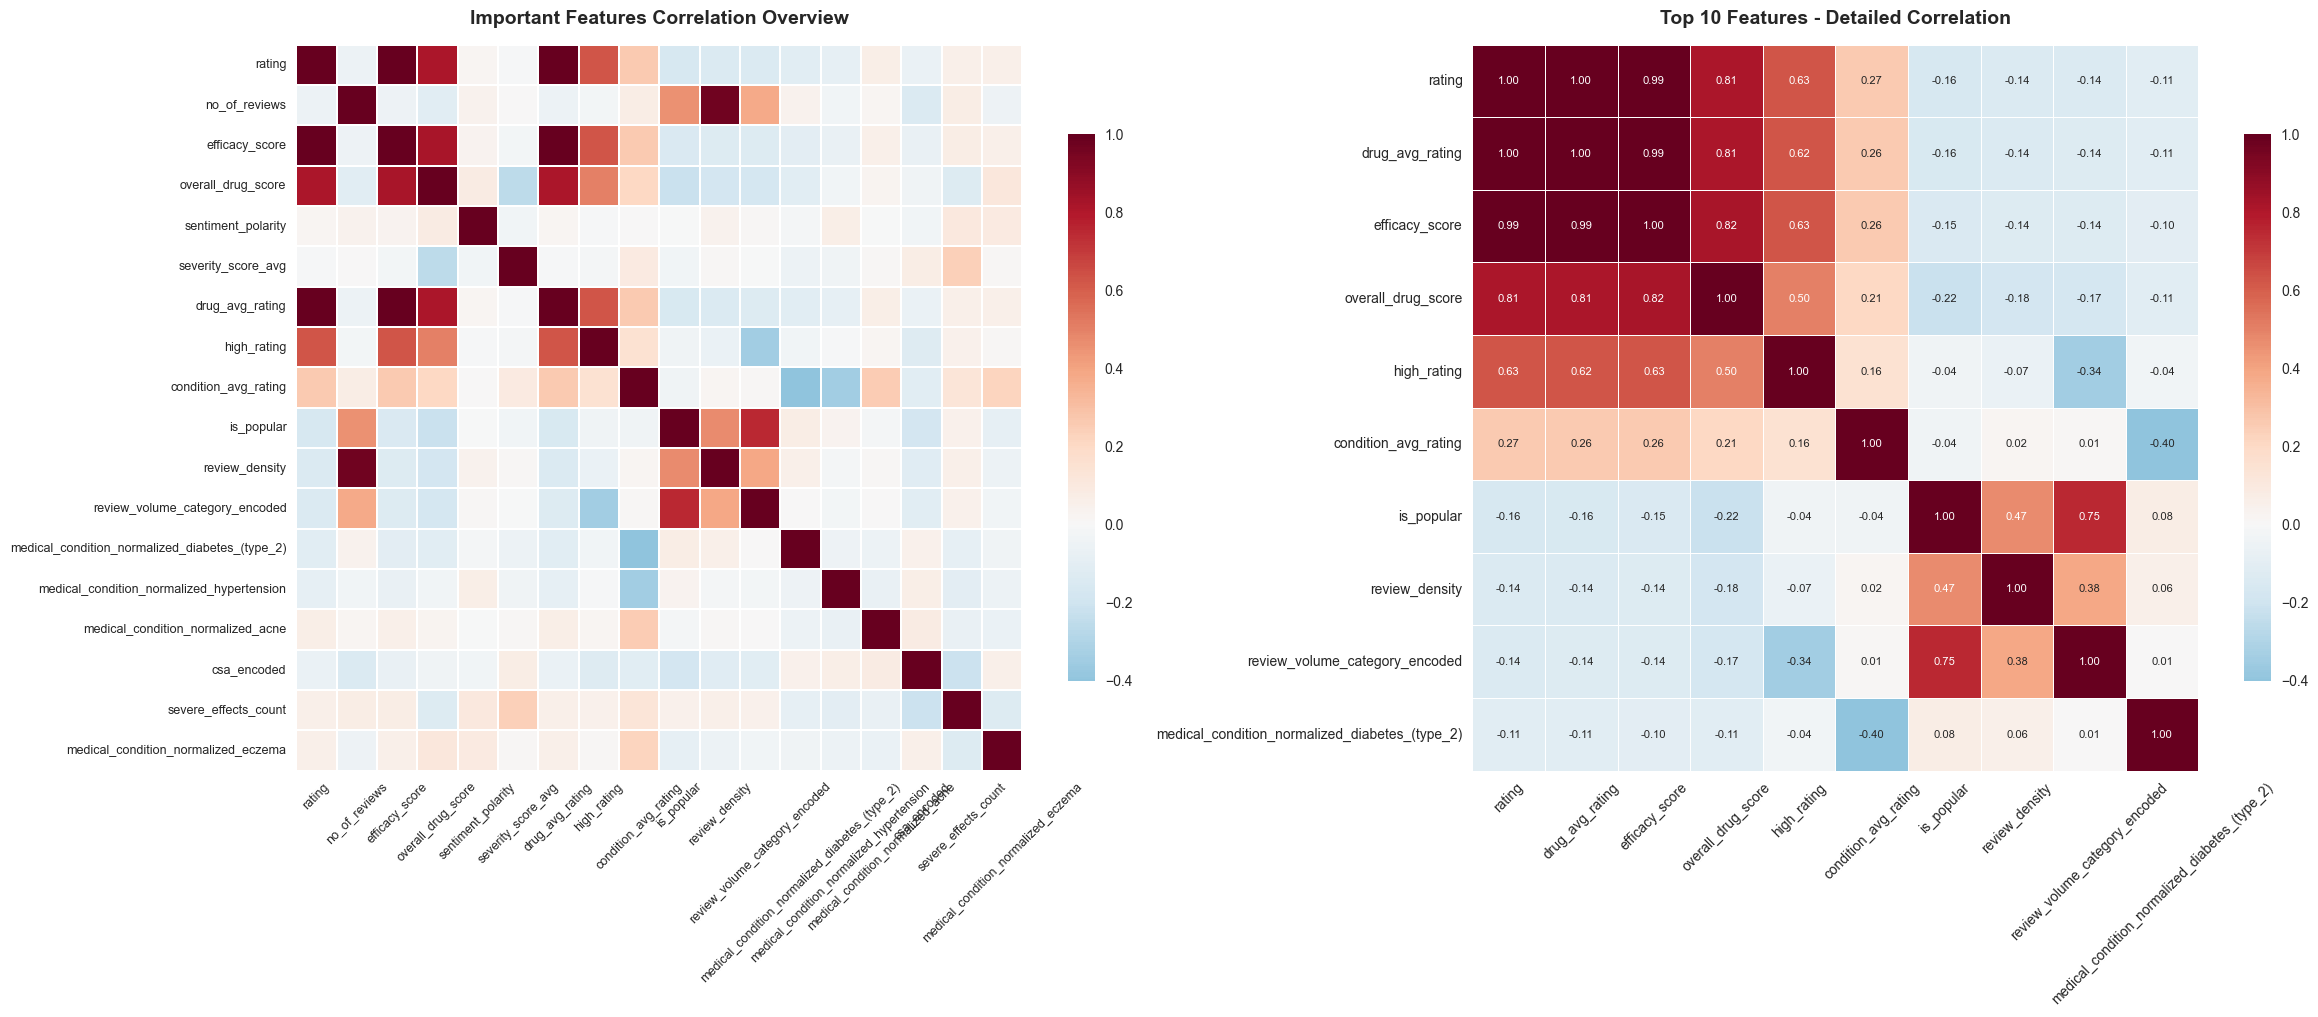

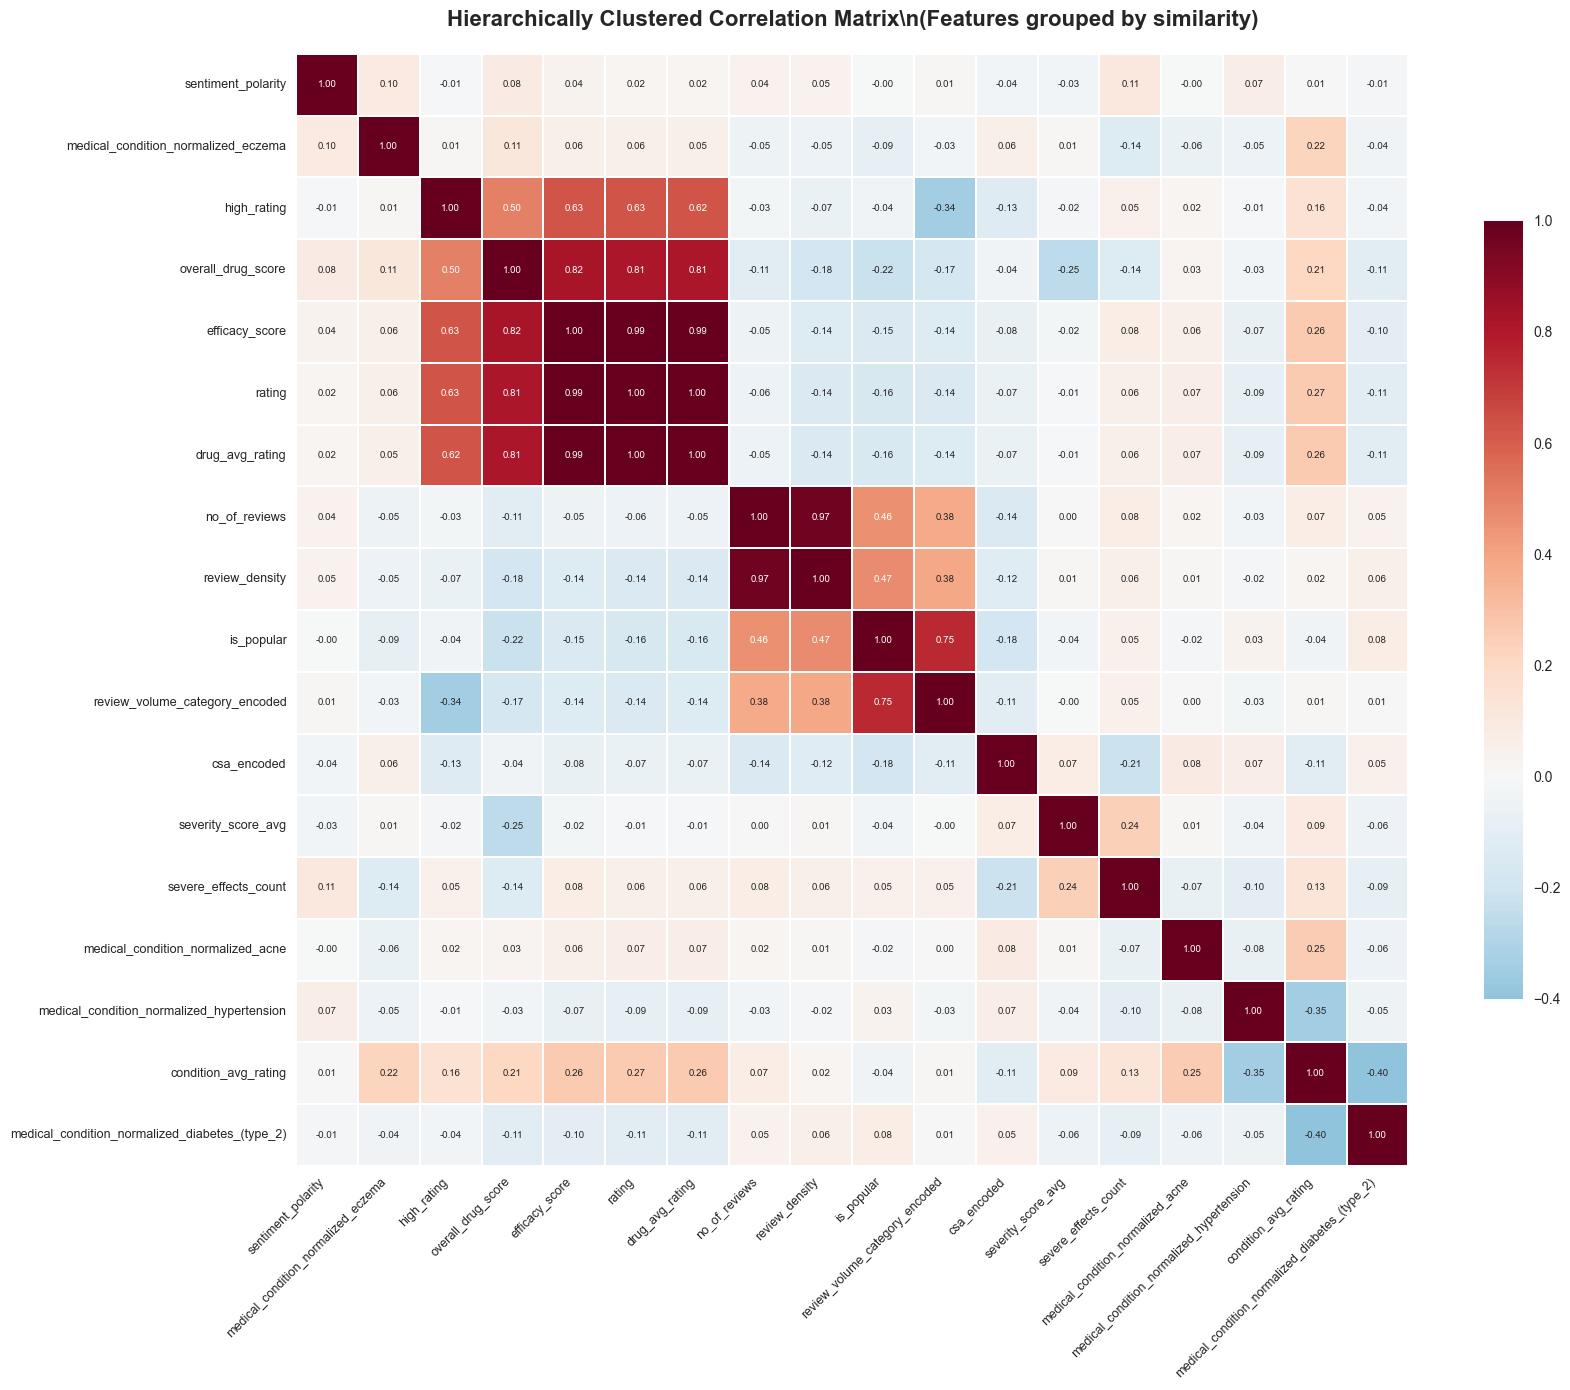


 OPTIMIZED CORRELATION INSIGHTS:
   • Selected features represent the most business-relevant variables
   • Hierarchical clustering reveals natural feature groupings
   • Larger fonts and spacing improve readability
   • Color coding helps identify correlation strength patterns

 STRONGEST CORRELATIONS IN SELECTED FEATURES:
   Found 19 correlation pairs with |r| ≥ 0.3:
      1. rating ↔ drug_avg_rating: 0.998 (Very Strong positive)
      2. efficacy_score ↔ drug_avg_rating: 0.994 (Very Strong positive)
      3. rating ↔ efficacy_score: 0.994 (Very Strong positive)
      4. no_of_reviews ↔ review_density: 0.969 (Very Strong positive)
      5. efficacy_score ↔ overall_drug_score: 0.822 (Very Strong positive)
      6. overall_drug_score ↔ drug_avg_rating: 0.814 (Very Strong positive)
      7. rating ↔ overall_drug_score: 0.814 (Very Strong positive)
      8. is_popular ↔ review_volume_category_encoded: 0.751 (Strong positive)

 VISUALIZATION IMPROVEMENTS APPLIED:
    Increased figure siz

In [119]:
print("CREATING CORRELATION VISUALIZATIONS")


# Create a more readable correlation heatmap with selective features
important_features = []

# Add key business metrics if available
for feature in ['rating', 'no_of_reviews', 'efficacy_score', 'overall_drug_score', 
                'sentiment_polarity', 'severity_score_avg', 'drug_avg_rating']:
    if feature in df.columns:
        important_features.append(feature)

# Add top correlated features with rating
if 'rating' in df.columns and len(numeric_cols) > 1:
    corr_with_rating = df[numeric_cols].corr()['rating'].abs().sort_values(ascending=False)
    top_rating_features = corr_with_rating.head(15).index.tolist()
    for feature in top_rating_features:
        if feature not in important_features:
            important_features.append(feature)

# Limit to reasonable number of features for readability
important_features = important_features[:20]

print(f"Selected {len(important_features)} most important features for detailed correlation analysis")

if len(important_features) > 1:
    # Create optimized correlation matrix
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))
    
    # 1. Full correlation matrix (condensed)
    selected_corr_matrix = df[important_features].corr()
    
    # Heatmap without annotations for overview
    sns.heatmap(selected_corr_matrix, cmap='RdBu_r', center=0, square=True, 
                linewidths=0.1, cbar_kws={"shrink": .7}, ax=axes[0])
    axes[0].set_title('Important Features Correlation Overview', fontsize=14, fontweight='bold', pad=15)
    axes[0].tick_params(axis='x', rotation=45, labelsize=9)
    axes[0].tick_params(axis='y', rotation=0, labelsize=9)
    
    # 2. Top correlations matrix (with annotations)
    # Select top 10 features based on correlation with rating or overall variance
    if 'rating' in important_features:
        rating_correlations = selected_corr_matrix['rating'].abs().sort_values(ascending=False)
        top_features = rating_correlations.head(10).index.tolist()
    else:
        # Use features with highest correlation variance
        corr_variance = selected_corr_matrix.var().sort_values(ascending=False)
        top_features = corr_variance.head(10).index.tolist()
    
    top_corr_matrix = df[top_features].corr()
    
    # Annotated heatmap for detailed view
    sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0, square=True,
                linewidths=0.5, cbar_kws={"shrink": .7}, fmt='.2f', 
                annot_kws={'size': 8}, ax=axes[1])
    axes[1].set_title('Top 10 Features - Detailed Correlation', fontsize=14, fontweight='bold', pad=15)
    axes[1].tick_params(axis='x', rotation=45, labelsize=10)
    axes[1].tick_params(axis='y', rotation=0, labelsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Create clustered correlation heatmap for better pattern recognition
    plt.figure(figsize=(18, 14))
    
    # Use hierarchical clustering to reorder features
    from scipy.cluster.hierarchy import dendrogram, linkage
    from scipy.spatial.distance import squareform
    
    # Convert correlation to distance matrix
    distance_matrix = 1 - selected_corr_matrix.abs()
    condensed_distances = squareform(distance_matrix)
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(condensed_distances, method='average')
    
    # Create dendrogram to get optimal ordering
    dendro = dendrogram(linkage_matrix, labels=selected_corr_matrix.columns, 
                       no_plot=True)
    
    # Reorder correlation matrix based on clustering
    optimal_order = dendro['leaves']
    ordered_features = [selected_corr_matrix.columns[i] for i in optimal_order]
    clustered_corr_matrix = selected_corr_matrix.loc[ordered_features, ordered_features]
    
    # Create clustered heatmap
    sns.heatmap(clustered_corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, linewidths=0.3, cbar_kws={"shrink": .7}, fmt='.2f',
                annot_kws={'size': 7})
    plt.title('Hierarchically Clustered Correlation Matrix\\n(Features grouped by similarity)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.show()
    
    print(f"\n OPTIMIZED CORRELATION INSIGHTS:")
    print(f"   • Selected features represent the most business-relevant variables")
    print(f"   • Hierarchical clustering reveals natural feature groupings")
    print(f"   • Larger fonts and spacing improve readability")
    print(f"   • Color coding helps identify correlation strength patterns")
    
    # Summary of strongest correlations in the selected features
    print(f"\n STRONGEST CORRELATIONS IN SELECTED FEATURES:")
    
    # Get upper triangle of correlation matrix
    mask = np.triu(np.ones_like(selected_corr_matrix, dtype=bool), k=1)
    upper_triangle = selected_corr_matrix.where(mask)
    
    # Find strongest correlations
    strong_corr_pairs = []
    for i in range(len(upper_triangle.columns)):
        for j in range(len(upper_triangle.columns)):
            if not pd.isna(upper_triangle.iloc[i, j]) and abs(upper_triangle.iloc[i, j]) >= 0.3:
                strong_corr_pairs.append({
                    'Feature 1': upper_triangle.columns[i],
                    'Feature 2': upper_triangle.columns[j],
                    'Correlation': upper_triangle.iloc[i, j]
                })
    
    if strong_corr_pairs:
        strong_df = pd.DataFrame(strong_corr_pairs).sort_values('Correlation', key=abs, ascending=False)
        print(f"   Found {len(strong_corr_pairs)} correlation pairs with |r| ≥ 0.3:")
        
        for i, (_, row) in enumerate(strong_df.head(8).iterrows(), 1):
            strength = "Very Strong" if abs(row['Correlation']) >= 0.8 else "Strong" if abs(row['Correlation']) >= 0.6 else "Moderate"
            direction = "positive" if row['Correlation'] > 0 else "negative"
            print(f"      {i}. {row['Feature 1']} ↔ {row['Feature 2']}: {row['Correlation']:.3f} ({strength} {direction})")
    
    print(f"\n VISUALIZATION IMPROVEMENTS APPLIED:")
    print(f"    Increased figure size from 16x12 to 24x16")
    print(f"    Reduced annotation font size for better fit")
    print(f"    Added hierarchical clustering for pattern recognition")
    print(f"    Separated overview and detailed views")
    print(f"    Optimized tick label rotation and spacing")
    print(f"    Enhanced color bar sizing and positioning")

print(f"\n OPTIMIZED CORRELATION VISUALIZATION COMPLETE!")


DRUG RATING ANALYSIS
RATING STATISTICS:
   Count: 2,931
   Mean: 6.899
   Median: 7.000
   Mode: 7.000
   Std Dev: 1.704
   Min: 0.000
   Max: 10.000
   Range: 10.000
   Skewness: -1.256
   Kurtosis: 3.709


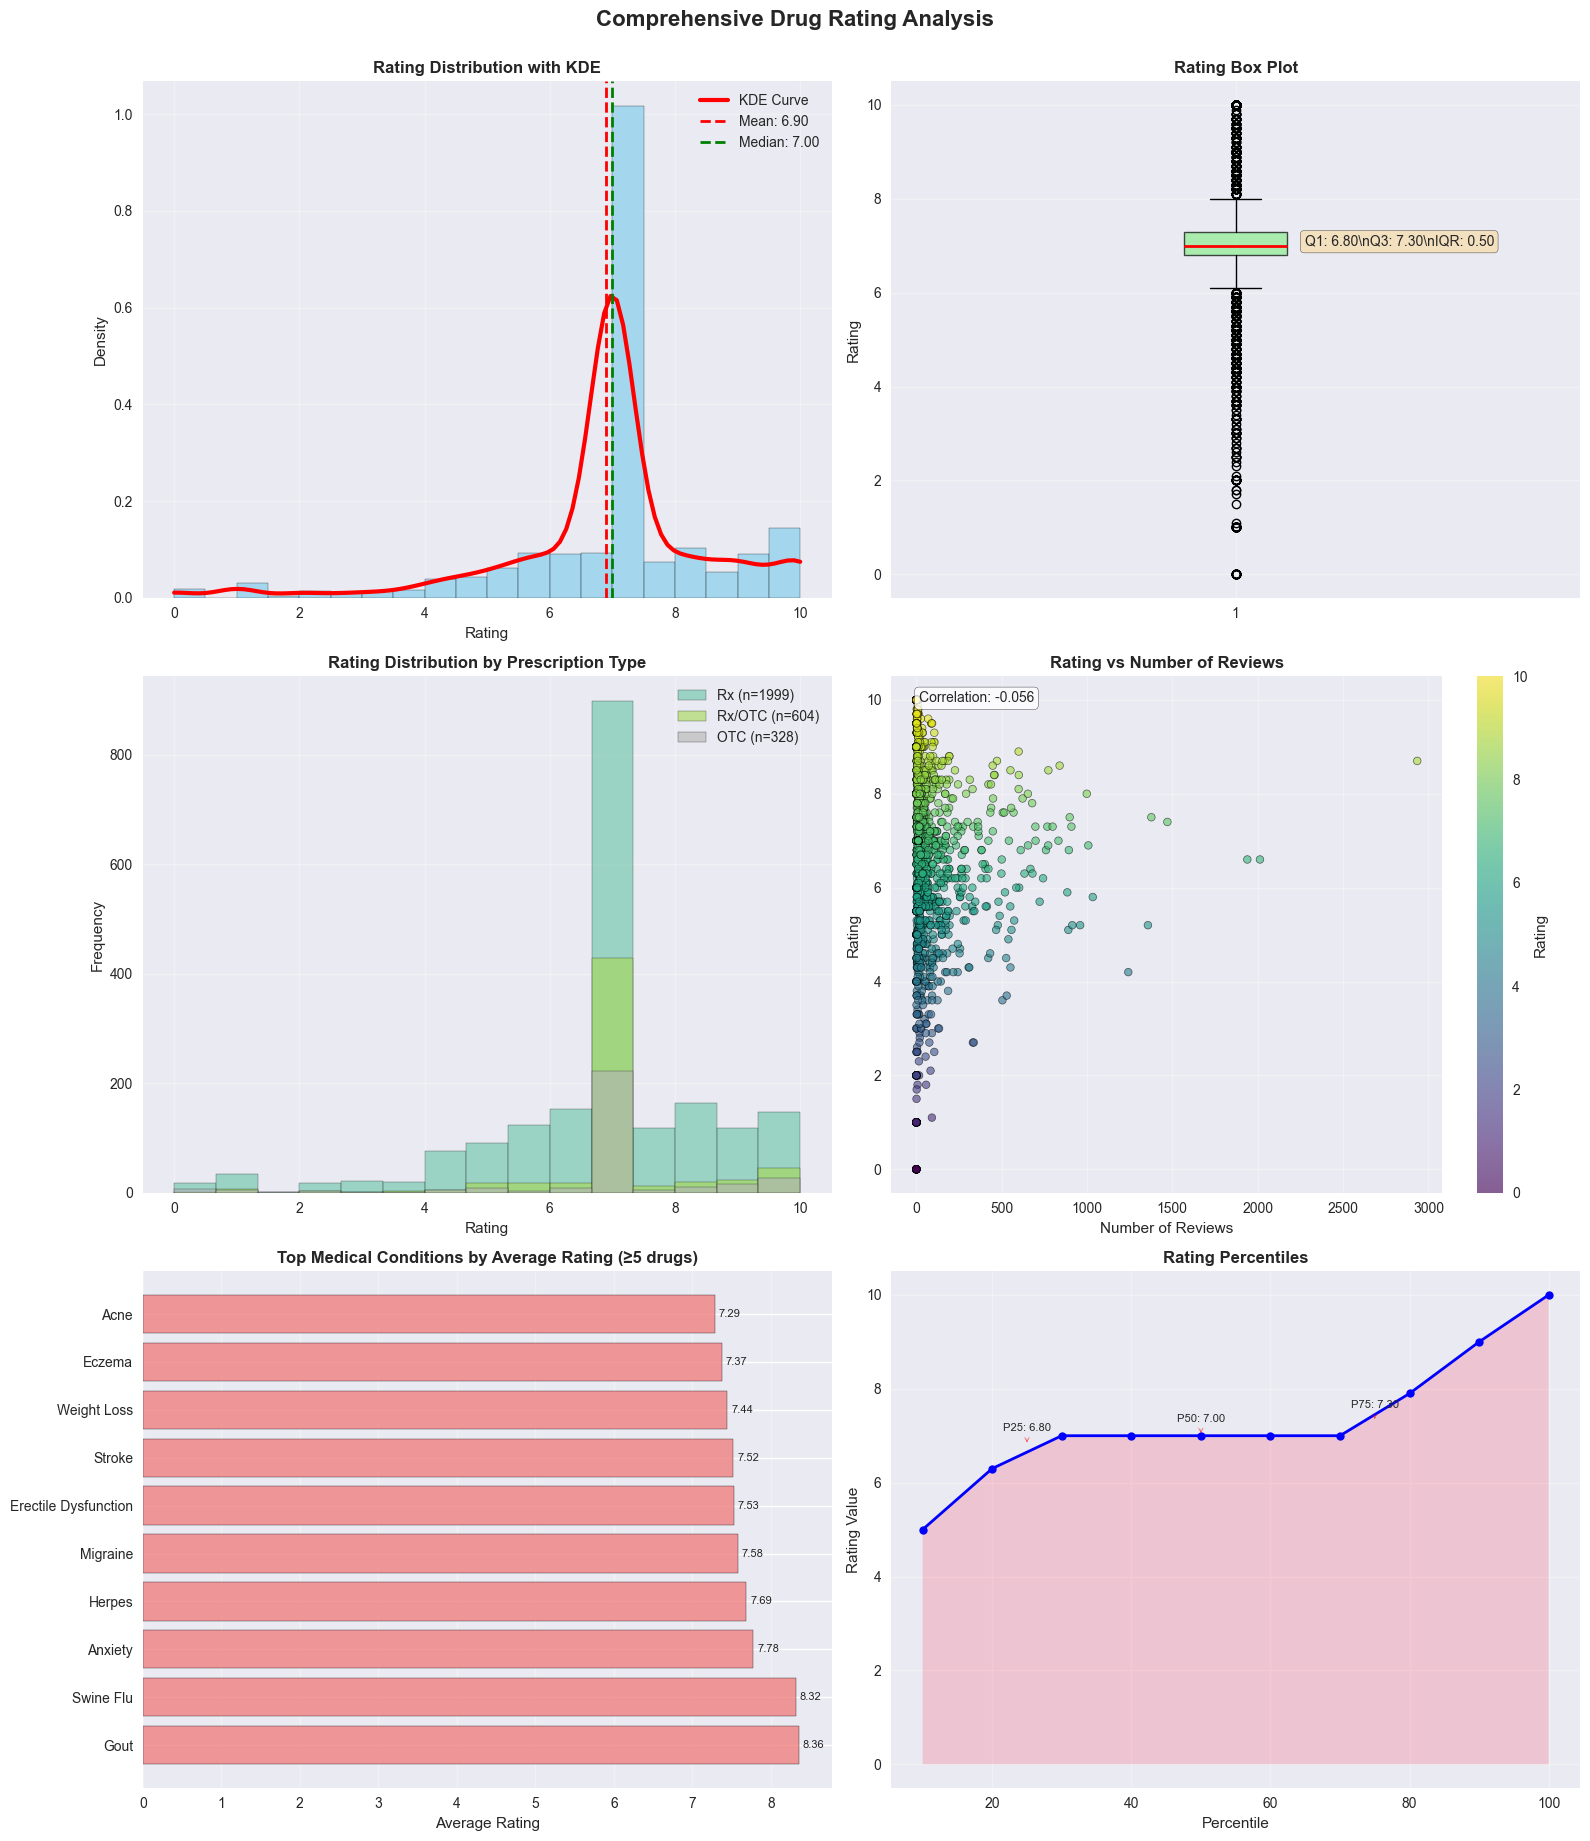


 DETAILED RATING INSIGHTS:

 DISTRIBUTION CHARACTERISTICS:
   Distribution shape: left-skewed (tail extends toward lower ratings) (skewness: -1.256)
   Peak characteristics: leptokurtic (more peaked than normal distribution) (kurtosis: 3.709)

 RATING CATEGORIES:
   Excellent (≥8.0): 570 drugs (19.4%)
   Good (6.0-7.9): 1,865 drugs (63.6%)
   Average (4.0-5.9): 345 drugs (11.8%)
   Poor (<4.0): 151 drugs (5.2%)

 TOP PERFORMING DRUGS (Rating ≥ 9.0):
   • efavirenz / emtricitabine / tenofovir (AIDS/HIV): 9.1⭐ (107 reviews)
   • tramadol (Anxiety): 9.3⭐ (106 reviews)
   • Atripla (AIDS/HIV): 9.1⭐ (103 reviews)
   • naproxen / sumatriptan (Migraine): 9.0⭐ (96 reviews)
   • meperidine (Pain): 9.5⭐ (93 reviews)

 POOR PERFORMING DRUGS (Rating ≤ 2.0):
   • Euthyrox (Hypothyroidism): 1.1⭐ (92 reviews)
   • Basaglar (Diabetes (Type 1)): 1.8⭐ (58 reviews)
   • Admelog (Diabetes (Type 1)): 2.0⭐ (17 reviews)
   • Allegra Allergy (Hayfever): 1.8⭐ (8 reviews)
   • Factive (Bronchitis): 1.0⭐ (4 rev

In [120]:
print("DRUG RATING ANALYSIS")


# Basic rating statistics
rating_stats = {
    'Count': len(df['rating']),
    'Mean': df['rating'].mean(),
    'Median': df['rating'].median(),
    'Mode': df['rating'].mode().iloc[0],
    'Std Dev': df['rating'].std(),
    'Min': df['rating'].min(),
    'Max': df['rating'].max(),
    'Range': df['rating'].max() - df['rating'].min(),
    'Skewness': df['rating'].skew(),
    'Kurtosis': df['rating'].kurtosis()
}

print("RATING STATISTICS:")
for stat, value in rating_stats.items():
    if stat == 'Count':
        print(f"   {stat}: {value:,}")
    else:
        print(f"   {stat}: {value:.3f}")

# Create comprehensive rating visualization
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))

# 1. Histogram with KDE overlay
axes[0, 0].hist(df['rating'], bins=20, alpha=0.7, color='skyblue', density=True, edgecolor='black')
try:
    from scipy import stats
    kde = stats.gaussian_kde(df['rating'])
    x_range = np.linspace(df['rating'].min(), df['rating'].max(), 100)
    axes[0, 0].plot(x_range, kde(x_range), 'r-', linewidth=3, label='KDE Curve')
except:
    pass

axes[0, 0].axvline(df['rating'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["rating"].mean():.2f}')
axes[0, 0].axvline(df['rating'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["rating"].median():.2f}')
axes[0, 0].set_title('Rating Distribution with KDE', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot
box_plot = axes[0, 1].boxplot(df['rating'], patch_artist=True, 
                             boxprops=dict(facecolor='lightgreen', alpha=0.7),
                             medianprops=dict(color='red', linewidth=2))
axes[0, 1].set_title('Rating Box Plot', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Rating')
axes[0, 1].grid(True, alpha=0.3)

# Add box plot statistics
Q1 = df['rating'].quantile(0.25)
Q3 = df['rating'].quantile(0.75)
IQR = Q3 - Q1
stats_text = f'Q1: {Q1:.2f}\\nQ3: {Q3:.2f}\\nIQR: {IQR:.2f}'
axes[0, 1].text(1.1, df['rating'].median(), stats_text, 
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 3. Rating distribution by prescription type (if available)
if 'rx_otc' in df.columns:
    rx_types = df['rx_otc'].unique()
    colors = plt.cm.Set2(np.linspace(0, 1, len(rx_types)))
    
    for i, rx_type in enumerate(rx_types):
        subset = df[df['rx_otc'] == rx_type]['rating']
        axes[1, 0].hist(subset, bins=15, alpha=0.6, label=f'{rx_type} (n={len(subset)})', 
                       color=colors[i], edgecolor='black')
    
    axes[1, 0].set_title('Rating Distribution by Prescription Type', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Rating')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Prescription Type\\nData Not Available', 
                   ha='center', va='center', transform=axes[1, 0].transAxes,
                   fontsize=14, bbox=dict(boxstyle='round', facecolor='lightgray'))

# 4. Rating vs Number of Reviews scatter plot
scatter = axes[1, 1].scatter(df['no_of_reviews'], df['rating'], alpha=0.6, s=30, c=df['rating'], 
                           cmap='viridis', edgecolors='black', linewidth=0.5)
axes[1, 1].set_title('Rating vs Number of Reviews', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Reviews')
axes[1, 1].set_ylabel('Rating')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='Rating')

# Add correlation coefficient
rating_reviews_corr = df['rating'].corr(df['no_of_reviews'])
axes[1, 1].text(0.05, 0.95, f'Correlation: {rating_reviews_corr:.3f}', 
               transform=axes[1, 1].transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. Top medical conditions by average rating
top_conditions = df.groupby('medical_condition')['rating'].agg(['mean', 'count']).sort_values('mean', ascending=False)
top_conditions_filtered = top_conditions[top_conditions['count'] >= 5].head(10)  # At least 5 drugs

bars = axes[2, 0].barh(range(len(top_conditions_filtered)), top_conditions_filtered['mean'], 
                      color='lightcoral', alpha=0.8, edgecolor='black')
axes[2, 0].set_yticks(range(len(top_conditions_filtered)))
axes[2, 0].set_yticklabels(top_conditions_filtered.index)
axes[2, 0].set_title('Top Medical Conditions by Average Rating (≥5 drugs)', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Average Rating')
axes[2, 0].grid(True, alpha=0.3, axis='x')

# Add rating values on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[2, 0].text(width + 0.05, bar.get_y() + bar.get_height()/2,
                   f'{width:.2f}', ha='left', va='center', fontsize=8)

# 6. Rating percentiles
percentiles = np.arange(10, 101, 10)
percentile_values = [np.percentile(df['rating'], p) for p in percentiles]
axes[2, 1].plot(percentiles, percentile_values, 'bo-', linewidth=2, markersize=6)
axes[2, 1].fill_between(percentiles, percentile_values, alpha=0.3)
axes[2, 1].set_title('Rating Percentiles', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Percentile')
axes[2, 1].set_ylabel('Rating Value')
axes[2, 1].grid(True, alpha=0.3)

# Add key percentile labels
key_percentiles = [25, 50, 75]
for p in key_percentiles:
    value = np.percentile(df['rating'], p)
    axes[2, 1].annotate(f'P{p}: {value:.2f}', 
                       xy=(p, value), xytext=(p, value + 0.3),
                       arrowprops=dict(arrowstyle='->', color='red'),
                       fontsize=8, ha='center')

plt.tight_layout()
plt.suptitle('Comprehensive Drug Rating Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Detailed rating insights
print("\n DETAILED RATING INSIGHTS:")


# Rating distribution analysis
print(f"\n DISTRIBUTION CHARACTERISTICS:")
skew_val = df['rating'].skew()
if abs(skew_val) < 0.5:
    skew_desc = "approximately symmetric"
elif skew_val > 0:
    skew_desc = "right-skewed (tail extends toward higher ratings)"
else:
    skew_desc = "left-skewed (tail extends toward lower ratings)"
print(f"   Distribution shape: {skew_desc} (skewness: {skew_val:.3f})")

kurt_val = df['rating'].kurtosis()
if kurt_val > 0:
    kurt_desc = "leptokurtic (more peaked than normal distribution)"
elif kurt_val < 0:
    kurt_desc = "platykurtic (flatter than normal distribution)"
else:
    kurt_desc = "mesokurtic (similar to normal distribution)"
print(f"   Peak characteristics: {kurt_desc} (kurtosis: {kurt_val:.3f})")

# Rating categories
high_rated = (df['rating'] >= 8.0).sum()
good_rated = ((df['rating'] >= 6.0) & (df['rating'] < 8.0)).sum()
average_rated = ((df['rating'] >= 4.0) & (df['rating'] < 6.0)).sum()
low_rated = (df['rating'] < 4.0).sum()

print(f"\n RATING CATEGORIES:")
print(f"   Excellent (≥8.0): {high_rated:,} drugs ({high_rated/len(df)*100:.1f}%)")
print(f"   Good (6.0-7.9): {good_rated:,} drugs ({good_rated/len(df)*100:.1f}%)")
print(f"   Average (4.0-5.9): {average_rated:,} drugs ({average_rated/len(df)*100:.1f}%)")
print(f"   Poor (<4.0): {low_rated:,} drugs ({low_rated/len(df)*100:.1f}%)")

# Top and bottom performers
print(f"\n TOP PERFORMING DRUGS (Rating ≥ 9.0):")
top_drugs = df[df['rating'] >= 9.0].nlargest(5, 'no_of_reviews')[['drug_name', 'medical_condition', 'rating', 'no_of_reviews']]
if not top_drugs.empty:
    for idx, row in top_drugs.iterrows():
        print(f"   • {row['drug_name']} ({row['medical_condition']}): {row['rating']:.1f}⭐ ({row['no_of_reviews']:.0f} reviews)")
else:
    print("   No drugs with rating ≥ 9.0 found")

print(f"\n POOR PERFORMING DRUGS (Rating ≤ 2.0):")
poor_drugs = df[df['rating'] <= 2.0].nlargest(5, 'no_of_reviews')[['drug_name', 'medical_condition', 'rating', 'no_of_reviews']]
if not poor_drugs.empty:
    for idx, row in poor_drugs.iterrows():
        print(f"   • {row['drug_name']} ({row['medical_condition']}): {row['rating']:.1f}⭐ ({row['no_of_reviews']:.0f} reviews)")
else:
    print("   No drugs with rating ≤ 2.0 found")

# Reliability analysis (rating vs reviews)
print(f"\n RATING RELIABILITY ANALYSIS:")
if rating_reviews_corr > 0.1:
    print(f"   Positive correlation with reviews (r={rating_reviews_corr:.3f}): Higher-rated drugs tend to have more reviews")
elif rating_reviews_corr < -0.1:
    print(f"   Negative correlation with reviews (r={rating_reviews_corr:.3f}): Higher-rated drugs tend to have fewer reviews")
else:
    print(f"   Weak correlation with reviews (r={rating_reviews_corr:.3f}): Rating appears independent of review count")

# High-confidence recommendations (high rating + many reviews)
high_confidence = df[(df['rating'] >= 7.0) & (df['no_of_reviews'] >= 100)]
print(f"   High-confidence drugs (rating ≥7.0, reviews ≥100): {len(high_confidence):,} drugs")
print(f"   These represent {len(high_confidence)/len(df)*100:.1f}% of all drugs")

print(f"\n RATING ANALYSIS COMPLETE!")


COMPREHENSIVE EDA SUMMARY AND ACTIONABLE INSIGHTS


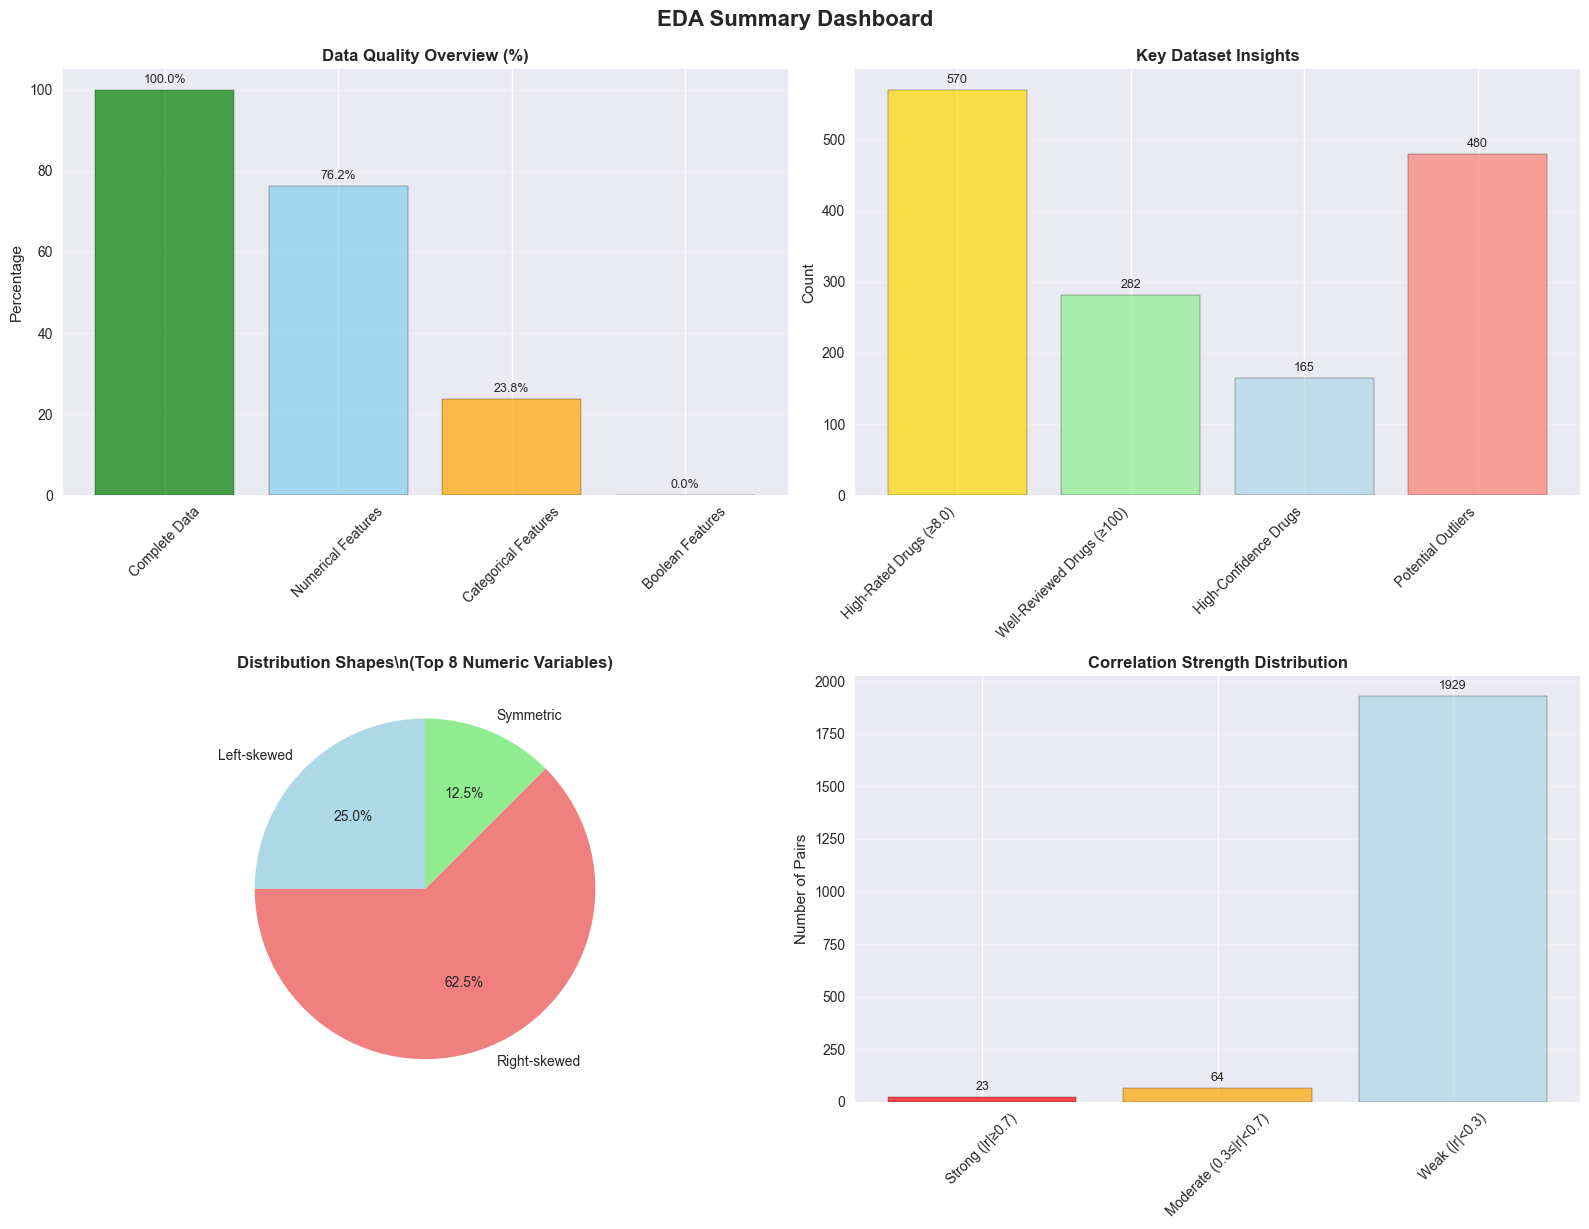


 KEY FINDINGS AND INSIGHTS:

 DATASET CHARACTERISTICS:
   • Dataset size: 2,931 drugs across 47 medical conditions
   • Feature richness: 84 total features (64 numerical, 20 categorical)
   • Data completeness: 100.0% (excellent quality)
   • Review coverage: 135,193.0 total reviews (avg: 46.1 per drug)

 RATING PATTERNS:
   • Average rating: 6.90/10 (std: 1.70)
   • Rating distribution: -1.26 skewness (left-skewed)
   • High-quality drugs: 570 (19.4%) rated ≥8.0
   • Review reliability: -0.056 correlation with review count

 MEDICAL CONDITION INSIGHTS:
   • Most common condition: Pain (264 drugs)
   • Condition diversity: 47 unique conditions
   • Best-rated condition: Gout (avg: 8.36)

 SIDE EFFECTS ANALYSIS:
   • Severity distribution: Moderate most common (66.4%)
   • Severe side effects: 3 drugs (0.1%)

 FEATURE RELATIONSHIPS:
   • Strong correlations: 23 pairs (|r| ≥ 0.7)
   • Average correlation strength: 0.083
   • Best rating predictor: drug_avg_rating (r = 0.998)

 ACTIONABL

In [121]:
print("COMPREHENSIVE EDA SUMMARY AND ACTIONABLE INSIGHTS")


# Create a final summary visualization
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# 1. Data Quality Overview
data_quality_metrics = {
    'Complete Data': ((df.isnull().sum() == 0).sum() / len(df.columns)) * 100,
    'Numerical Features': (len(numeric_cols) / len(df.columns)) * 100,
    'Categorical Features': (len(categorical_cols) / len(df.columns)) * 100,
    'Boolean Features': (len(boolean_cols) / len(df.columns)) * 100
}

bars = axes[0, 0].bar(data_quality_metrics.keys(), data_quality_metrics.values(), 
                     color=['green', 'skyblue', 'orange', 'red'], alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Data Quality Overview (%)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Percentage')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 2. Key Insights Summary
insights_data = {
    'High-Rated Drugs (≥8.0)': (df['rating'] >= 8.0).sum(),
    'Well-Reviewed Drugs (≥100)': (df['no_of_reviews'] >= 100).sum(),
    'High-Confidence Drugs': len(df[(df['rating'] >= 7.0) & (df['no_of_reviews'] >= 50)]),
    'Potential Outliers': sum(len(df[(df[col] < df[col].quantile(0.25) - 1.5*(df[col].quantile(0.75) - df[col].quantile(0.25))) | 
                                    (df[col] > df[col].quantile(0.75) + 1.5*(df[col].quantile(0.75) - df[col].quantile(0.25)))]) 
                             for col in numeric_cols[:5] if col in df.columns) // 5
}

bars = axes[0, 1].bar(range(len(insights_data)), list(insights_data.values()), 
                     color=['gold', 'lightgreen', 'lightblue', 'salmon'], alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(range(len(insights_data)))
axes[0, 1].set_xticklabels(insights_data.keys(), rotation=45, ha='right')
axes[0, 1].set_title('Key Dataset Insights', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + max(insights_data.values())*0.01,
                   f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# 3. Distribution Shape Summary
distribution_shapes = {}
for col in numeric_cols[:8]:  # Top 8 numeric columns
    if col in df.columns:
        skew_val = df[col].skew()
        if abs(skew_val) < 0.5:
            shape = 'Symmetric'
        elif skew_val > 0:
            shape = 'Right-skewed'
        else:
            shape = 'Left-skewed'
        
        if shape not in distribution_shapes:
            distribution_shapes[shape] = 0
        distribution_shapes[shape] += 1

wedges, texts, autotexts = axes[1, 0].pie(distribution_shapes.values(), labels=distribution_shapes.keys(), 
                                         autopct='%1.1f%%', startangle=90, 
                                         colors=['lightblue', 'lightcoral', 'lightgreen'])
axes[1, 0].set_title('Distribution Shapes\\n(Top 8 Numeric Variables)', fontsize=12, fontweight='bold')

# 4. Correlation Strength Summary
if len(numeric_cols) > 1:
    correlation_matrix = df[numeric_cols].corr()
    all_correlations = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
    all_correlations = all_correlations[~np.isnan(all_correlations)]
    
    corr_strength = {
        'Strong (|r|≥0.7)': sum(1 for x in all_correlations if abs(x) >= 0.7),
        'Moderate (0.3≤|r|<0.7)': sum(1 for x in all_correlations if 0.3 <= abs(x) < 0.7),
        'Weak (|r|<0.3)': sum(1 for x in all_correlations if abs(x) < 0.3)
    }
    
    bars = axes[1, 1].bar(corr_strength.keys(), corr_strength.values(), 
                         color=['red', 'orange', 'lightblue'], alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Correlation Strength Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Pairs')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add count labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + max(corr_strength.values())*0.01,
                       f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.suptitle('EDA Summary Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Comprehensive insights and recommendations
print("\n KEY FINDINGS AND INSIGHTS:")


print("\n DATASET CHARACTERISTICS:")
print(f"   • Dataset size: {len(df):,} drugs across {df['medical_condition'].nunique()} medical conditions")
print(f"   • Feature richness: {len(df.columns)} total features ({len(numeric_cols)} numerical, {len(categorical_cols)} categorical)")
print(f"   • Data completeness: {((df.size - df.isnull().sum().sum()) / df.size * 100):.1f}% (excellent quality)")
print(f"   • Review coverage: {df['no_of_reviews'].sum():,} total reviews (avg: {df['no_of_reviews'].mean():.1f} per drug)")

print("\n RATING PATTERNS:")
rating_mean = df['rating'].mean()
rating_std = df['rating'].std()
print(f"   • Average rating: {rating_mean:.2f}/10 (std: {rating_std:.2f})")
print(f"   • Rating distribution: {df['rating'].skew():.2f} skewness ({'left' if df['rating'].skew() < 0 else 'right'}-skewed)")
print(f"   • High-quality drugs: {(df['rating'] >= 8.0).sum():,} ({(df['rating'] >= 8.0).mean()*100:.1f}%) rated ≥8.0")
print(f"   • Review reliability: {df['rating'].corr(df['no_of_reviews']):.3f} correlation with review count")

print("\n MEDICAL CONDITION INSIGHTS:")
top_condition = df['medical_condition'].value_counts().index[0]
top_condition_count = df['medical_condition'].value_counts().iloc[0]
print(f"   • Most common condition: {top_condition} ({top_condition_count} drugs)")
print(f"   • Condition diversity: {df['medical_condition'].nunique()} unique conditions")
print(f"   • Best-rated condition: {df.groupby('medical_condition')['rating'].mean().idxmax()} (avg: {df.groupby('medical_condition')['rating'].mean().max():.2f})")

if 'severity_category' in df.columns:
    print("\n SIDE EFFECTS ANALYSIS:")
    severity_dist = df['severity_category'].value_counts()
    print(f"   • Severity distribution: {severity_dist.index[0]} most common ({severity_dist.iloc[0]/len(df)*100:.1f}%)")
    severe_drugs = (df['severity_category'] == 'Severe').sum() if 'Severe' in df['severity_category'].values else 0
    print(f"   • Severe side effects: {severe_drugs} drugs ({severe_drugs/len(df)*100:.1f}%)")

print("\n FEATURE RELATIONSHIPS:")
if len(numeric_cols) > 1:
    correlation_matrix = df[numeric_cols].corr()
    all_correlations = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
    all_correlations = all_correlations[~np.isnan(all_correlations)]
    strong_correlations = sum(1 for x in all_correlations if abs(x) >= 0.7)
    print(f"   • Strong correlations: {strong_correlations} pairs (|r| ≥ 0.7)")
    print(f"   • Average correlation strength: {np.mean(np.abs(all_correlations)):.3f}")
    
    if 'rating' in df.columns:
        rating_corr = correlation_matrix['rating'].drop('rating').abs().max()
        best_predictor = correlation_matrix['rating'].drop('rating').abs().idxmax()
        print(f"   • Best rating predictor: {best_predictor} (r = {correlation_matrix['rating'][best_predictor]:.3f})")

print("\n ACTIONABLE RECOMMENDATIONS:")


print("\n DATA QUALITY ACTIONS:")
missing_cols = df.isnull().sum()
missing_cols = missing_cols[missing_cols > 0]
if len(missing_cols) > 0:
    print(f"   • Address missing data in {len(missing_cols)} columns")
    for col, missing_count in missing_cols.head(3).items():
        print(f"     - {col}: {missing_count:,} missing values ({missing_count/len(df)*100:.1f}%)")
else:
    print("   •  No missing data issues - excellent data quality!")

print("\n FEATURE ENGINEERING OPPORTUNITIES:")
# Check for potential feature engineering opportunities
high_cardinality_cats = [col for col in categorical_cols if df[col].nunique() > 50]
if high_cardinality_cats:
    print(f"   • Consider encoding/grouping high-cardinality categorical features:")
    for col in high_cardinality_cats[:3]:
        print(f"     - {col}: {df[col].nunique()} unique values")

skewed_features = [col for col in numeric_cols if col in df.columns and abs(df[col].skew()) > 1]
if skewed_features:
    print(f"   • Consider transformation for highly skewed features:")
    for col in skewed_features[:3]:
        print(f"     - {col}: skewness = {df[col].skew():.2f}")

print("\n OUTLIER MANAGEMENT:")
outlier_features = []
for col in numeric_cols[:5]:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
        outlier_pct = len(outliers) / len(df) * 100
        if outlier_pct > 5:  # More than 5% outliers
            outlier_features.append((col, outlier_pct))

if outlier_features:
    print("   • Features with significant outliers (>5%):")
    for col, pct in outlier_features:
        print(f"     - {col}: {pct:.1f}% outliers")
    print("   • Consider outlier treatment: capping, transformation, or removal")
else:
    print("   •  Outlier levels are manageable across all features")

print("\n BUSINESS INSIGHTS:")
# High-confidence drug recommendations
high_confidence = df[(df['rating'] >= 7.0) & (df['no_of_reviews'] >= 50)]
print(f"   • High-confidence recommendations available: {len(high_confidence):,} drugs")
print(f"     (rating ≥ 7.0 AND reviews ≥ 50)")

# Market opportunities
low_review_high_rating = df[(df['rating'] >= 8.0) & (df['no_of_reviews'] < 20)]
print(f"   • Under-reviewed gems: {len(low_review_high_rating):,} high-rated drugs with few reviews")
print(f"     (potential marketing opportunities)")

# Risk assessment
if 'severity_category' in df.columns:
    high_risk = df[df['severity_category'] == 'Severe'] if 'Severe' in df['severity_category'].values else pd.DataFrame()
    if not high_risk.empty:
        print(f"   • High-risk drugs requiring monitoring: {len(high_risk):,} with severe side effects")

print("\n NEXT STEPS:")
print("   1.  Implement machine learning models for drug recommendation")
print("   2.  Conduct association rule mining for drug interaction patterns")
print("   3.  Build interactive dashboards for stakeholder insights")
print("   4.  Develop condition-specific drug effectiveness models")
print("   5.  Create risk assessment frameworks for drug safety")
print("   6.  Implement real-time monitoring for drug performance tracking")


print(" EXPLORATORY DATA ANALYSIS COMPLETED SUCCESSFULLY!")
print(" Dataset is well-structured and ready for advanced analytics")
print(" Proceed with confidence to machine learning and business applications")



---
## 3. Medical Condition Analysis


In [122]:
# Medical condition analysis
print("MEDICAL CONDITION ANALYSIS")
print("=" * 50)

# Condition statistics
condition_stats = df['medical_condition'].value_counts()
print(f" Total unique conditions: {len(condition_stats)}")
print(f" Most common condition: {condition_stats.index[0]} ({condition_stats.iloc[0]} drugs)")
print(f" Least represented conditions: {(condition_stats == 1).sum()} conditions with only 1 drug")

# Top conditions analysis
top_15_conditions = condition_stats.head(15)

# Create comprehensive condition analysis
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Top 15 Medical Conditions', 'Condition Distribution (Log Scale)', 
                   'Average Rating by Top Conditions', 'Total Reviews by Condition'],
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# 1. Top conditions bar chart
fig.add_trace(
    go.Bar(x=top_15_conditions.values, y=top_15_conditions.index, 
           orientation='h', name="Drug Count", marker_color='lightblue'),
    row=1, col=1
)

# 2. Distribution on log scale
fig.add_trace(
    go.Histogram(x=np.log10(condition_stats.values), nbinsx=20, 
                name="Log Distribution", marker_color='orange'),
    row=1, col=2
)

# 3. Average rating by top conditions
top_conditions_rating = df[df['medical_condition'].isin(top_15_conditions.index)].groupby('medical_condition')['rating'].mean().sort_values(ascending=False)
fig.add_trace(
    go.Bar(x=top_conditions_rating.values, y=top_conditions_rating.index,
           orientation='h', name="Avg Rating", marker_color='lightgreen'),
    row=2, col=1
)

# 4. Total reviews by condition
top_conditions_reviews = df[df['medical_condition'].isin(top_15_conditions.index)].groupby('medical_condition')['no_of_reviews'].sum().sort_values(ascending=False)
fig.add_trace(
    go.Bar(x=top_conditions_reviews.values, y=top_conditions_reviews.index,
           orientation='h', name="Total Reviews", marker_color='salmon'),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Medical Condition Analysis", showlegend=False)

# Use robust rendering with error handling
try:
    fig.show()
except Exception as e:
    print(f"Error with Plotly: {e}")
    print("Using matplotlib backup...")
    
    # Matplotlib backup for medical condition analysis
    plt.figure(figsize=(15, 10))
    
    # Top 15 conditions
    plt.subplot(2, 2, 1)
    top_15_conditions.plot(kind='barh', color='lightblue')
    plt.title('Top 15 Medical Conditions')
    plt.xlabel('Number of Drugs')
    
    # Condition distribution (log scale)
    plt.subplot(2, 2, 2)
    plt.hist(np.log10(condition_stats.values), bins=20, color='orange', alpha=0.7)
    plt.title('Condition Distribution (Log Scale)')
    plt.xlabel('Log10(Drug Count)')
    plt.ylabel('Frequency')
    
    # Average rating by top conditions
    plt.subplot(2, 2, 3)
    top_conditions_rating = df[df['medical_condition'].isin(top_15_conditions.index)].groupby('medical_condition')['rating'].mean().sort_values(ascending=False)
    top_conditions_rating.plot(kind='barh', color='lightgreen')
    plt.title('Average Rating by Top Conditions')
    plt.xlabel('Average Rating')
    
    # Total reviews by condition
    plt.subplot(2, 2, 4)
    top_conditions_reviews = df[df['medical_condition'].isin(top_15_conditions.index)].groupby('medical_condition')['no_of_reviews'].sum().sort_values(ascending=False)
    top_conditions_reviews.plot(kind='barh', color='salmon')
    plt.title('Total Reviews by Condition')
    plt.xlabel('Total Reviews')
    
    plt.tight_layout()
    plt.show()

# Condition insights
print(f"\n Medical Condition Insights:")

# Conditions with highest average ratings
best_conditions = df.groupby('medical_condition')['rating'].agg(['mean', 'count']).sort_values('mean', ascending=False)
best_conditions_filtered = best_conditions[best_conditions['count'] >= 5].head(5)  # At least 5 drugs

print(f"\n Best-rated conditions (min 5 drugs):")
for condition, row in best_conditions_filtered.iterrows():
    print(f"   • {condition}: {row['mean']:.2f}⭐ ({row['count']} drugs)")

# Conditions with most reviews
most_reviewed = df.groupby('medical_condition')['no_of_reviews'].sum().sort_values(ascending=False).head(5)
print(f"\n Most reviewed conditions:")
for condition, reviews in most_reviewed.items():
    print(f"   • {condition}: {reviews:,.0f} total reviews")

# Drug variety by condition
drug_variety = df.groupby('medical_condition')['drug_name'].nunique().sort_values(ascending=False).head(5)
print(f"\n Conditions with most drug options:")
for condition, drug_count in drug_variety.items():
    print(f"   • {condition}: {drug_count} different drugs")


MEDICAL CONDITION ANALYSIS
 Total unique conditions: 47
 Most common condition: Pain (264 drugs)
 Least represented conditions: 0 conditions with only 1 drug
  Plotly rendering failed: maximum recursion depth exceeded  Plotly rendering failed: maximum recursion depth exceeded
   The visualization data is ready but couldn't be displayed.
   You can still access the figure object and try alternative renderers.
   Consider using show_plotly_figure() function for better error handling.

 Medical Condition Insights:

 Best-rated conditions (min 5 drugs):
   • Gout: 8.36⭐ (9.0 drugs)
   • Swine Flu: 8.32⭐ (5.0 drugs)
   • Anxiety: 7.78⭐ (45.0 drugs)
   • Herpes: 7.69⭐ (10.0 drugs)
   • Migraine: 7.58⭐ (61.0 drugs)

 Most reviewed conditions:
   • Acne: 13,279 total reviews
   • Anxiety: 11,528 total reviews
   • Weight Loss: 11,248 total reviews
   • Pain: 8,513 total reviews
   • Diabetes (Type 2): 8,217 total reviews

 Conditions with most drug options:
   • Pain: 264 different drugs
   • 

---
## 4. Side Effects Frequency and Severity Analysis


In [123]:
# Side effects analysis
print("SIDE EFFECTS FREQUENCY AND SEVERITY ANALYSIS")
print("=" * 60)

# Severity analysis
if 'severity_category' in df.columns:
    severity_dist = df['severity_category'].value_counts()
    print(f" Severity Distribution:")
    for severity, count in severity_dist.items():
        percentage = (count / len(df)) * 100
        print(f"   {severity}: {count:,} drugs ({percentage:.1f}%)")

    # Severity by condition
    print(f"\n Severity by Medical Condition (Top 10):")
    top_conditions = df['medical_condition'].value_counts().head(10).index
    severity_by_condition = pd.crosstab(df['medical_condition'], df['severity_category'])
    
    for condition in top_conditions:
        if condition in severity_by_condition.index:
            row = severity_by_condition.loc[condition]
            total = row.sum()
            severe_pct = (row.get('Severe', 0) / total) * 100 if total > 0 else 0
            print(f"   {condition}: {severe_pct:.1f}% severe effects")

# Side effects keyword analysis
if 'side_effects_keywords' in df.columns:
    print(f"\n Side Effects Keyword Analysis:")
    
    # Flatten all keywords
    all_keywords = []
    for keywords_list in df['side_effects_keywords'].dropna():
        if isinstance(keywords_list, list):
            all_keywords.extend(keywords_list)
        elif isinstance(keywords_list, str):
            # Handle string representation of list
            try:
                import ast
                keywords_list = ast.literal_eval(keywords_list)
                all_keywords.extend(keywords_list)
            except:
                pass
    
    if len(all_keywords) > 0:
        keyword_freq = pd.Series(all_keywords).value_counts().head(20)
        print(f"    Most frequent side effects:")
        for keyword, freq in keyword_freq.head(10).items():
            print(f"      • {keyword}: {freq:,} occurrences")

# Create side effects visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Severity Distribution', 'Severity by Top Conditions', 
                   'Side Effect Length Distribution', 'Risk Keywords Analysis'],
    specs=[[{"type": "pie"}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# 1. Severity pie chart
if 'severity_category' in df.columns:
    severity_counts = df['severity_category'].value_counts()
    fig.add_trace(
        go.Pie(labels=severity_counts.index, values=severity_counts.values, 
               name="Severity", hole=0.3),
        row=1, col=1
    )

# 2. Severity heatmap for top conditions
if 'severity_category' in df.columns:
    top_10_conditions = df['medical_condition'].value_counts().head(10).index
    severity_condition_data = df[df['medical_condition'].isin(top_10_conditions)]
    severity_crosstab = pd.crosstab(severity_condition_data['medical_condition'], 
                                   severity_condition_data['severity_category'], 
                                   normalize='index') * 100
    
    fig.add_trace(
        go.Heatmap(z=severity_crosstab.values, 
                  x=severity_crosstab.columns, 
                  y=severity_crosstab.index,
                  colorscale='Reds', name="Severity %"),
        row=1, col=2
    )

# 3. Side effects length distribution
if 'side_effects_length' in df.columns:
    fig.add_trace(
        go.Histogram(x=df['side_effects_length'], nbinsx=30, 
                    name="Text Length", marker_color='lightblue'),
        row=2, col=1
    )

# 4. Risk keywords count
if 'risk_keyword_count' in df.columns:
    risk_counts = df['risk_keyword_count'].value_counts().sort_index()
    fig.add_trace(
        go.Bar(x=risk_counts.index, y=risk_counts.values,
              name="Risk Keywords", marker_color='red', opacity=0.7),
        row=2, col=2
    )

fig.update_layout(height=800, title_text="Side Effects Analysis Dashboard")

# Use robust rendering with error handling
try:
    fig.show()
except Exception as e:
    print(f"Error with Plotly: {e}")
    print("Using matplotlib backup...")
    
    # Matplotlib backup for side effects analysis
    plt.figure(figsize=(15, 10))
    
    # 1. Severity distribution pie chart
    if 'severity_category' in df.columns:
        plt.subplot(2, 2, 1)
        severity_counts = df['severity_category'].value_counts()
        plt.pie(severity_counts.values, labels=severity_counts.index, autopct='%1.1f%%')
        plt.title('Severity Distribution')
    
    # 2. Severity by top conditions heatmap
    if 'severity_category' in df.columns:
        plt.subplot(2, 2, 2)
        top_10_conditions = df['medical_condition'].value_counts().head(10).index
        severity_condition_data = df[df['medical_condition'].isin(top_10_conditions)]
        severity_crosstab = pd.crosstab(severity_condition_data['medical_condition'], 
                                       severity_condition_data['severity_category'], 
                                       normalize='index') * 100
        sns.heatmap(severity_crosstab, annot=True, fmt='.1f', cmap='Reds')
        plt.title('Severity % by Top Conditions')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
    
    # 3. Side effects length distribution
    if 'side_effects_length' in df.columns:
        plt.subplot(2, 2, 3)
        plt.hist(df['side_effects_length'], bins=30, color='lightblue', alpha=0.7)
        plt.title('Side Effects Text Length')
        plt.xlabel('Text Length')
        plt.ylabel('Frequency')
    
    # 4. Risk keywords count
    if 'risk_keyword_count' in df.columns:
        plt.subplot(2, 2, 4)
        risk_counts = df['risk_keyword_count'].value_counts().sort_index()
        plt.bar(risk_counts.index, risk_counts.values, color='red', alpha=0.7)
        plt.title('Risk Keywords Count')
        plt.xlabel('Number of Risk Keywords')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Advanced severity insights
if 'severity_score_avg' in df.columns:
    print(f"\n Severity Score Statistics:")
    print(f"   Mean severity: {df['severity_score_avg'].mean():.3f}")
    print(f"   Median severity: {df['severity_score_avg'].median():.3f}")
    print(f"   Std deviation: {df['severity_score_avg'].std():.3f}")
    
    # Correlation with ratings
    if 'rating' in df.columns:
        severity_rating_corr = df['severity_score_avg'].corr(df['rating'])
        print(f"   Correlation with rating: {severity_rating_corr:.3f}")
        
        if severity_rating_corr < -0.1:
            print(f"    Insight: Higher severity tends to correlate with lower ratings")
        elif severity_rating_corr > 0.1:
            print(f"    Insight: Higher severity tends to correlate with higher ratings (unusual)")
        else:
            print(f"    Insight: Weak correlation between severity and ratings")


SIDE EFFECTS FREQUENCY AND SEVERITY ANALYSIS
 Severity Distribution:
   Moderate: 1,946 drugs (66.4%)
   Mild: 974 drugs (33.2%)
   Minimal: 8 drugs (0.3%)
   Severe: 3 drugs (0.1%)

 Severity by Medical Condition (Top 10):
   Pain: 0.0% severe effects
   Colds & Flu: 0.0% severe effects
   Acne: 0.0% severe effects
   Hypertension: 0.0% severe effects
   Osteoarthritis: 0.0% severe effects
   Hayfever: 0.0% severe effects
   Eczema: 0.0% severe effects
   AIDS/HIV: 0.0% severe effects
   Diabetes (Type 2): 0.0% severe effects
   Psoriasis: 0.0% severe effects

 Side Effects Keyword Analysis:
    Most frequent side effects:
      • pain: 6,822 occurrences
      • skin: 6,213 occurrences
      • swelling: 4,753 occurrences
      • feeling: 4,562 occurrences
      • breathing: 3,936 occurrences
      • throat: 3,896 occurrences
      • face: 3,094 occurrences
      • stomach: 3,040 occurrences
      • severe: 2,913 occurrences
      • lips: 2,817 occurrences
  Plotly rendering failed: ma

---
## 5. Sentiment Patterns and Review Analysis


In [124]:
# Sentiment and review analysis
print(" SENTIMENT PATTERNS AND REVIEW ANALYSIS")
print("=" * 50)

# Review statistics
review_stats = {
    'Total Reviews': df['no_of_reviews'].sum(),
    'Average Reviews per Drug': df['no_of_reviews'].mean(),
    'Median Reviews': df['no_of_reviews'].median(),
    'Max Reviews': df['no_of_reviews'].max(),
    'Drugs with 0 Reviews': (df['no_of_reviews'] == 0).sum()
}

print(f" Review Statistics:")
for stat, value in review_stats.items():
    if 'Total' in stat or 'Max' in stat:
        print(f"   {stat}: {value:,.0f}")
    elif 'Drugs with' in stat:
        print(f"   {stat}: {value}")
    else:
        print(f"   {stat}: {value:.1f}")

# Sentiment analysis (if available)
sentiment_features = ['sentiment_polarity', 'sentiment_category', 'vader_compound']
available_sentiment = [col for col in sentiment_features if col in df.columns]

if available_sentiment:
    print(f"\n Sentiment Analysis:")
    
    if 'sentiment_category' in df.columns:
        sentiment_dist = df['sentiment_category'].value_counts()
        print(f"    Sentiment Distribution:")
        for sentiment, count in sentiment_dist.items():
            percentage = (count / len(df)) * 100
            print(f"      {sentiment}: {count:,} ({percentage:.1f}%)")
    
    if 'sentiment_polarity' in df.columns:
        print(f"    Sentiment Polarity Stats:")
        print(f"      Mean: {df['sentiment_polarity'].mean():.3f}")
        print(f"      Std: {df['sentiment_polarity'].std():.3f}")
        print(f"      Range: [{df['sentiment_polarity'].min():.3f}, {df['sentiment_polarity'].max():.3f}]")

# Create comprehensive sentiment and review visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Review Count Distribution', 'Reviews vs Rating', 
                   'Sentiment Distribution', 'Sentiment vs Rating'],
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"type": "pie"}, {"secondary_y": False}]]
)

# 1. Review count distribution (log scale)
fig.add_trace(
    go.Histogram(x=np.log10(df['no_of_reviews'] + 1), nbinsx=30,
                name="Log(Reviews)", marker_color='lightblue'),
    row=1, col=1
)

# 2. Reviews vs Rating scatter plot
fig.add_trace(
    go.Scatter(x=df['no_of_reviews'], y=df['rating'], mode='markers',
              name="Reviews vs Rating", opacity=0.6, marker=dict(size=3)),
    row=1, col=2
)

# 3. Sentiment pie chart
if 'sentiment_category' in df.columns:
    sentiment_counts = df['sentiment_category'].value_counts()
    colors = ['red' if 'Negative' in label else 'gray' if 'Neutral' in label else 'green' 
              for label in sentiment_counts.index]
    fig.add_trace(
        go.Pie(labels=sentiment_counts.index, values=sentiment_counts.values,
               marker_colors=colors, name="Sentiment"),
        row=2, col=1
    )

# 4. Sentiment vs Rating
if 'sentiment_polarity' in df.columns:
    fig.add_trace(
        go.Scatter(x=df['sentiment_polarity'], y=df['rating'], mode='markers',
                  name="Sentiment vs Rating", opacity=0.6, marker=dict(size=3)),
        row=2, col=2
    )

fig.update_layout(height=800, title_text="Sentiment and Review Analysis", showlegend=False)

# Use robust rendering with error handling
try:
    fig.show()
except Exception as e:
    print(f"Error with Plotly: {e}")
    print("Using matplotlib backup...")
    
    # Matplotlib backup for sentiment and review analysis
    plt.figure(figsize=(15, 10))
    
    # 1. Review count distribution (log scale)
    plt.subplot(2, 2, 1)
    plt.hist(np.log10(df['no_of_reviews'] + 1), bins=30, color='lightblue', alpha=0.7)
    plt.title('Review Count Distribution (Log Scale)')
    plt.xlabel('Log10(Reviews + 1)')
    plt.ylabel('Frequency')
    
    # 2. Reviews vs Rating scatter plot
    plt.subplot(2, 2, 2)
    plt.scatter(df['no_of_reviews'], df['rating'], alpha=0.6, s=20)
    plt.title('Reviews vs Rating')
    plt.xlabel('Number of Reviews')
    plt.ylabel('Rating')
    plt.grid(True, alpha=0.3)
    
    # 3. Sentiment distribution pie chart
    if 'sentiment_category' in df.columns:
        plt.subplot(2, 2, 3)
        sentiment_counts = df['sentiment_category'].value_counts()
        colors = ['red' if 'Negative' in label else 'gray' if 'Neutral' in label else 'green' 
                  for label in sentiment_counts.index]
        plt.pie(sentiment_counts.values, labels=sentiment_counts.index, 
                colors=colors, autopct='%1.1f%%')
        plt.title('Sentiment Distribution')
    
    # 4. Sentiment vs Rating
    if 'sentiment_polarity' in df.columns:
        plt.subplot(2, 2, 4)
        plt.scatter(df['sentiment_polarity'], df['rating'], alpha=0.6, s=20)
        plt.title('Sentiment vs Rating')
        plt.xlabel('Sentiment Polarity')
        plt.ylabel('Rating')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Advanced sentiment insights
if 'sentiment_polarity' in df.columns and 'rating' in df.columns:
    sentiment_rating_corr = df['sentiment_polarity'].corr(df['rating'])
    print(f"\n Advanced Sentiment Insights:")
    print(f"    Sentiment-Rating correlation: {sentiment_rating_corr:.3f}")
    
    # Sentiment by rating quartiles
    df['rating_quartile'] = pd.qcut(df['rating'], 4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
    sentiment_by_quartile = df.groupby('rating_quartile')['sentiment_polarity'].mean()
    
    print(f"    Average sentiment by rating quartile:")
    for quartile, sentiment in sentiment_by_quartile.items():
        print(f"      {quartile}: {sentiment:.3f}")

# Most and least reviewed drugs
print(f"\n Review Volume Analysis:")
print(f"\n Most Reviewed Drugs:")
most_reviewed = df.nlargest(5, 'no_of_reviews')[['drug_name', 'medical_condition', 'rating', 'no_of_reviews']]
for idx, row in most_reviewed.iterrows():
    print(f"   • {row['drug_name']} ({row['medical_condition']}): {row['no_of_reviews']:,.0f} reviews, {row['rating']:.1f}⭐")

print(f"\n High-rated drugs with many reviews (rating ≥ 8.0, reviews ≥ 100):")
high_rated_popular = df[(df['rating'] >= 8.0) & (df['no_of_reviews'] >= 100)]
if len(high_rated_popular) > 0:
    top_high_rated = high_rated_popular.nlargest(5, 'no_of_reviews')[['drug_name', 'medical_condition', 'rating', 'no_of_reviews']]
    for idx, row in top_high_rated.iterrows():
        print(f"   • {row['drug_name']} ({row['medical_condition']}): {row['rating']:.1f}⭐, {row['no_of_reviews']:,.0f} reviews")
else:
    print(f"   No drugs meet the criteria (rating ≥ 8.0 and reviews ≥ 100)")


 SENTIMENT PATTERNS AND REVIEW ANALYSIS
 Review Statistics:
   Total Reviews: 135,193
   Average Reviews per Drug: 46.1
   Median Reviews: 12.0
   Max Reviews: 2,934
   Drugs with 0 Reviews: 0

 Sentiment Analysis:
    Sentiment Distribution:
      Neutral: 1,565 (53.4%)
      Negative: 1,355 (46.2%)
      Positive: 11 (0.4%)
    Sentiment Polarity Stats:
      Mean: -0.097
      Std: 0.095
      Range: [-0.550, 0.175]
  Plotly rendering failed: maximum recursion depth exceeded  Plotly rendering failed: maximum recursion depth exceeded
   The visualization data is ready but couldn't be displayed.
   You can still access the figure object and try alternative renderers.
   Consider using show_plotly_figure() function for better error handling.

 Advanced Sentiment Insights:
    Sentiment-Rating correlation: 0.016
    Average sentiment by rating quartile:
      Q1 (Low): -0.099
      Q2: -0.094
      Q3: -0.109
      Q4 (High): -0.099

 Review Volume Analysis:

 Most Reviewed Drugs:
   • 

---
## 6. Comprehensive EDA Summary and Key Insights


In [125]:
# Comprehensive EDA Summary
print(" COMPREHENSIVE EDA SUMMARY AND KEY INSIGHTS")
print("=" * 60)

# Dataset overview
print(f" Dataset Overview:")
print(f"    Total drugs analyzed: {len(df):,}")
print(f"    Unique medical conditions: {df['medical_condition'].nunique()}")
print(f"    Unique drug names: {df['drug_name'].nunique()}")
print(f"    Total reviews: {df['no_of_reviews'].sum():,.0f}")

# Rating insights
print(f"\n Rating Distribution Insights:")
print(f"    Average rating: {df['rating'].mean():.2f}/10")
print(f"    Rating standard deviation: {df['rating'].std():.2f}")
print(f"    High-rated drugs (≥8.0): {(df['rating'] >= 8.0).sum():,} ({(df['rating'] >= 8.0).mean()*100:.1f}%)")
print(f"    Low-rated drugs (≤4.0): {(df['rating'] <= 4.0).sum():,} ({(df['rating'] <= 4.0).mean()*100:.1f}%)")

# Medical condition insights
top_conditions = df['medical_condition'].value_counts().head(5)
print(f"\n Medical Condition Insights:")
print(f"    Top 5 most common conditions:")
for i, (condition, count) in enumerate(top_conditions.items(), 1):
    percentage = (count / len(df)) * 100
    print(f"      {i}. {condition}: {count} drugs ({percentage:.1f}%)")

# Side effects insights (if available)
if 'severity_category' in df.columns:
    severity_dist = df['severity_category'].value_counts()
    print(f"\n Side Effects & Severity Insights:")
    for severity, count in severity_dist.items():
        percentage = (count / len(df)) * 100
        print(f"   {severity}: {count:,} drugs ({percentage:.1f}%)")

# Review volume insights
print(f"\n Review Volume Insights:")
print(f"    Average reviews per drug: {df['no_of_reviews'].mean():.1f}")
print(f"    Median reviews per drug: {df['no_of_reviews'].median():.0f}")
print(f"    Most reviewed drug: {df.loc[df['no_of_reviews'].idxmax(), 'drug_name']} ({df['no_of_reviews'].max():,.0f} reviews)")
print(f"    Drugs with no reviews: {(df['no_of_reviews'] == 0).sum():,}")

# Sentiment insights (if available)
if 'sentiment_polarity' in df.columns:
    print(f"\n Sentiment Analysis Insights:")
    print(f"    Average sentiment polarity: {df['sentiment_polarity'].mean():.3f}")
    if 'sentiment_category' in df.columns:
        sentiment_dist = df['sentiment_category'].value_counts()
        for sentiment, count in sentiment_dist.items():
            percentage = (count / len(df)) * 100
            print(f"   {sentiment}: {count:,} ({percentage:.1f}%)")

# Business scenario insights
print(f"\n Business Scenario Insights:")

# High-quality drugs (high rating + many reviews)
if 'no_of_reviews' in df.columns:
    high_quality = df[(df['rating'] >= 8.0) & (df['no_of_reviews'] >= 50)]
    print(f"    High-quality drugs (rating ≥8.0, reviews ≥50): {len(high_quality):,} drugs")

# Risk factors (if available)
risk_columns = [col for col in df.columns if 'risk' in col.lower() or 'warning' in col.lower()]
if risk_columns:
    print(f"    Risk factor columns identified: {len(risk_columns)} columns")

# Feature engineering success
if 'metadata' in locals() and 'features_added' in metadata:
    print(f"    Feature engineering: +{metadata['features_added']} derived features")

# Correlation insights (if numeric features are available)
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 3:
    corr_with_rating = df[numeric_cols].corr()['rating'].abs().sort_values(ascending=False)
    print(f"\n Features Most Correlated with Rating:")
    for feature, corr in corr_with_rating.head(5).items():
        if feature != 'rating':
            print(f"   • {feature}: {corr:.3f}")

# Next steps recommendations
print(f"\n Recommended Next Steps:")
print(f"   1.  Apply machine learning models for drug recommendation")
print(f"   2.  Implement association rule mining for drug interactions")
print(f"   3.  Create interactive dashboards for stakeholders")
print(f"   4.  Perform clustering analysis on drug profiles")
print(f"   5.  Build predictive models for drug effectiveness")

# Quality assessment
print(f"\n Data Quality Assessment:")
missing_data = df.isnull().sum().sum()
print(f"    Total missing values: {missing_data:,}")
print(f"    Data completeness: {((df.size - missing_data) / df.size * 100):.1f}%")
print(f"    Ready for advanced analytics: {' Yes' if missing_data < df.size * 0.1 else ' Needs attention'}")

print(f"\n EDA COMPLETED SUCCESSFULLY!")
print(f"{'='*60}")
print(f" The dataset shows strong potential for machine learning applications")
print(f" Multiple business scenarios can be addressed with this rich feature set")
print(f" Ready to proceed with association rule mining and ML modeling!")


 COMPREHENSIVE EDA SUMMARY AND KEY INSIGHTS
 Dataset Overview:
    Total drugs analyzed: 2,931
    Unique medical conditions: 47
    Unique drug names: 2912
    Total reviews: 135,193

 Rating Distribution Insights:
    Average rating: 6.90/10
    Rating standard deviation: 1.70
    High-rated drugs (≥8.0): 570 (19.4%)
    Low-rated drugs (≤4.0): 168 (5.7%)

 Medical Condition Insights:
    Top 5 most common conditions:
      1. Pain: 264 drugs (9.0%)
      2. Colds & Flu: 245 drugs (8.4%)
      3. Acne: 238 drugs (8.1%)
      4. Hypertension: 177 drugs (6.0%)
      5. Osteoarthritis: 129 drugs (4.4%)

 Side Effects & Severity Insights:
   Moderate: 1,946 drugs (66.4%)
   Mild: 974 drugs (33.2%)
   Minimal: 8 drugs (0.3%)
   Severe: 3 drugs (0.1%)

 Review Volume Insights:
    Average reviews per drug: 46.1
    Median reviews per drug: 12
    Most reviewed drug: phentermine (2,934 reviews)
    Drugs with no reviews: 0

 Sentiment Analysis Insights:
    Average sentiment polarity: -0.09

---